Installing required packages...
Packages installed successfully.
Libraries imported successfully.

--- Project: Accelerating Geospatial Image Classification ---

--- Starting Data Acquisition ---
Kagle API already configured.
Dataset already exists in 'EuroSAT'. Skipping download.


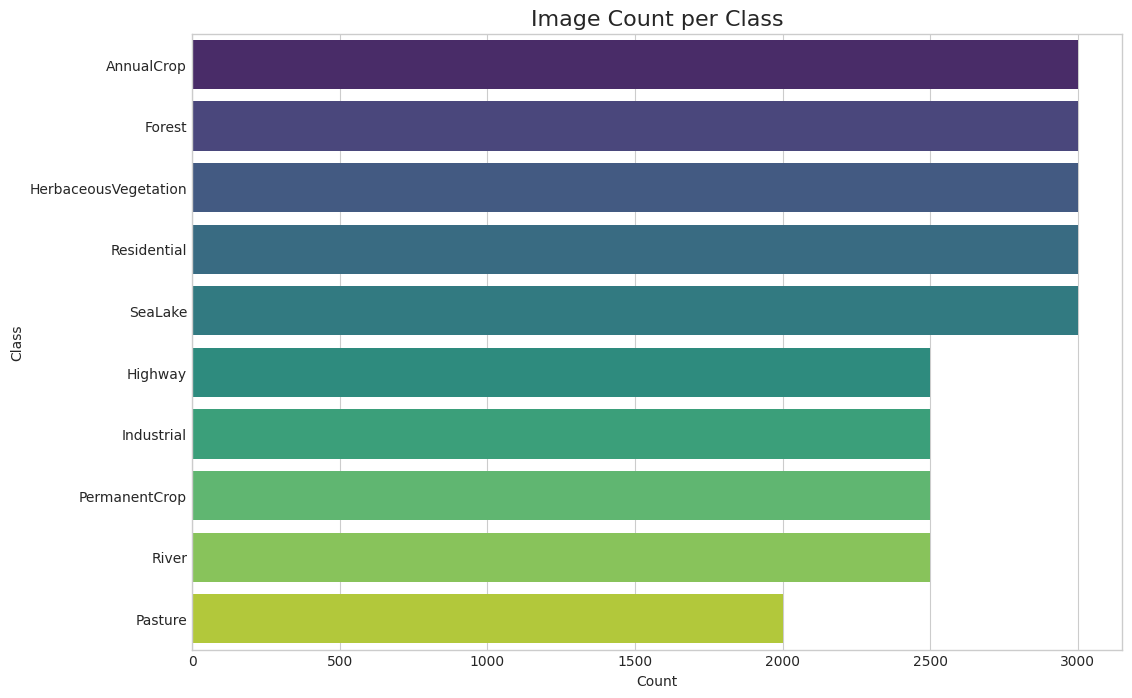


Dataset Analysis: {'AnnualCrop': 3000, 'Forest': 3000, 'HerbaceousVegetation': 3000, 'Highway': 2500, 'Industrial': 2500, 'Pasture': 2000, 'PermanentCrop': 2500, 'Residential': 3000, 'River': 2500, 'SeaLake': 3000}

Building TensorFlow data pipeline...
Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Data pipeline constructed successfully.


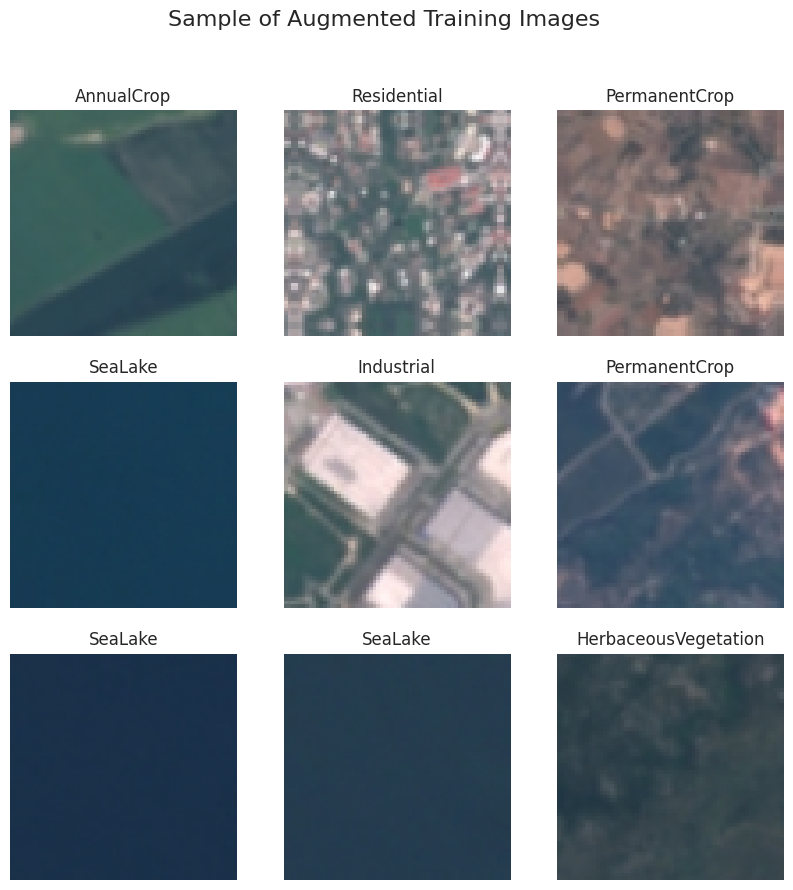

In [7]:
# Cell 1 & 2 (Consolidated & Final): Project Initialization, Environment, Data, and Pipeline

# --- 1. Installation of Dependencies ---
print("Installing required packages...")
!pip install -q kaggle scikit-learn seaborn
print("Packages installed successfully.")

# --- 2. Import Libraries ---
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from kaggle.api.kaggle_api_extended import KaggleApi
print("Libraries imported successfully.")

# --- Project Narrative ---
# (Your excellent project description remains here)
print("\n--- Project: Accelerating Geospatial Image Classification ---")


# --- 3. Kaggle API and Data Acquisition ---
print("\n--- Starting Data Acquisition ---")

KAGGLE_JSON_PATH = 'kaggle.json'
if not os.path.exists(os.path.expanduser('~/.kaggle/kaggle.json')):
    if os.path.exists(KAGGLE_JSON_PATH):
        print("Configuring Kaggle API from local kaggle.json...")
        !mkdir -p ~/.kaggle
        !cp {KAGGLE_JSON_PATH} ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    else:
        print("\nERROR: 'kaggle.json' not found. Please upload your Kaggle API token file and re-run.")
        from google.colab import files
        files.upload()
        !mkdir -p ~/.kaggle && cp {KAGGLE_JSON_PATH} ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
else:
    print("Kagle API already configured.")

DATA_DIR = "EuroSAT"
KAGGLE_DATASET_ID = "apollo2506/eurosat-dataset"

if not os.path.exists(DATA_DIR):
    try:
        api = KaggleApi()
        api.authenticate()
        print(f"Downloading dataset '{KAGGLE_DATASET_ID}'...")
        api.dataset_download_files(KAGGLE_DATASET_ID, path='.', unzip=True, quiet=False)
        print(f"Dataset successfully downloaded and unzipped.")
    except Exception as e:
        print(f"\n--- An error occurred during Kaggle download: {e} ---")
else:
    print(f"Dataset already exists in '{DATA_DIR}'. Skipping download.")


# --- 4. Configuration and EDA ---
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 64
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
plt.style.use('seaborn-v0_8-whitegrid')

if os.path.exists(DATA_DIR):
    class_names = []
    class_counts = []
    for folder in sorted(os.listdir(DATA_DIR)):
        folder_path = os.path.join(DATA_DIR, folder)
        if os.path.isdir(folder_path):
            class_names.append(folder)
            class_counts.append(len(os.listdir(folder_path)))

    df_counts = pd.DataFrame({'Class': class_names, 'Count': class_counts}).sort_values('Count', ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Class', data=df_counts, palette='viridis')
    plt.title('Image Count per Class', fontsize=16)
    plt.show()
    print("\nDataset Analysis:", dict(zip(class_names, class_counts)))
else:
    print(f"\nCannot perform EDA: Directory '{DATA_DIR}' not found.")


# --- 5. TensorFlow Data Pipeline ---
if os.path.exists(DATA_DIR):
    print("\nBuilding TensorFlow data pipeline...")

    full_dataset = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR, validation_split=0.2, subset='training', seed=SEED,
        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

    validation_test_dataset = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR, validation_split=0.2, subset='validation', seed=SEED,
        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

    # --- THIS IS THE CORRECTED PART ---
    # Split the reserved 20% into a 10% validation set and a 10% test set
    val_batches = tf.data.experimental.cardinality(validation_test_dataset)
    val_ds = validation_test_dataset.take(val_batches // 2)
    test_ds = validation_test_dataset.skip(val_batches // 2)
    # --- END OF CORRECTION ---

    rescale_layer = layers.Rescaling(1./255)
    augmentation_layer = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"), layers.RandomRotation(0.2), layers.RandomZoom(0.2)])

    def preprocess_dataset(dataset, training=False):
        dataset = dataset.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        if training:
            dataset = dataset.map(lambda x, y: (augmentation_layer(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    train_ds = preprocess_dataset(full_dataset, training=True)
    val_ds = preprocess_dataset(val_ds) # Now val_ds is defined
    test_ds = preprocess_dataset(test_ds) # Now test_ds is defined
    print("Data pipeline constructed successfully.")

    # Visualize a Batch of Augmented Images
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle("Sample of Augmented Training Images", fontsize=16)
    plt.show()
else:
    print(f"\nCannot build pipeline: Directory '{DATA_DIR}' not found.")

In [9]:
# Cell 3: ResNet Model Architecture

# --- Import necessary Keras components ---
# This was the missing import that caused the NameError
from tensorflow.keras import layers, models, Input

# --- 1. Define the Residual Block ---
# This is the core building block of a ResNet. It contains the "skip connection"
# that allows the gradient to flow directly through the network.
def residual_block(x, filters, conv_num=3, stride=1):
    # Shortcut path
    shortcut = x

    # If the output dimension is different (due to stride or more filters),
    # we need a 1x1 convolution on the shortcut path to match dimensions.
    if stride > 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Main path
    # Using a pre-activation ResNet block structure (BN -> ReLU -> Conv)
    for i in range(conv_num):
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        # Apply convolution. The first conv layer handles the stride.
        x = layers.Conv2D(filters, 3, strides=stride if i == 0 else 1, padding='same')(x)

    # Add the shortcut to the main path
    x = layers.Add()([x, shortcut])
    return x

# --- 2. Build the Full ResNet Model ---
def build_resnet(input_shape, num_classes, block_repeats=[2, 2, 2]):
    """
    Builds a custom ResNet model.
    Args:
        input_shape (tuple): Shape of the input images (e.g., (64, 64, 3)).
        num_classes (int): Number of output classes.
        block_repeats (list): List of integers specifying how many residual blocks
                              to stack in each stage.
    """
    input_tensor = Input(shape=input_shape)

    # --- Entry Flow ---
    # Start with a standard convolution layer to extract initial features.
    x = layers.Conv2D(32, 7, strides=2, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # --- Middle Flow (Stacking Residual Blocks) ---
    filters = 32
    for i, repeats in enumerate(block_repeats):
        for j in range(repeats):
            # Downsample at the start of each new stage (except the first)
            stride = 2 if j == 0 and i != 0 else 1
            filters *= 2 if j == 0 and i != 0 else 1
            x = residual_block(x, filters=filters, stride=stride)

    # --- Exit Flow ---
    # Final activation before pooling
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)

    # For uncertainty quantification, we add Dropout before the final layer.
    # It will be active during both training and inference (for MC Dropout).
    x = layers.Dropout(0.5)(x, training=True) # Always active for MC Dropout

    output_tensor = layers.Dense(num_classes, activation='softmax')(x)

    # The 'models' alias is now defined from the import above
    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model

# --- 3. Instantiate the Model ---
INPUT_SHAPE = IMAGE_SIZE + (3,)
NUM_CLASSES = len(class_names)

# Create the ResNet model instance
resnet_model = build_resnet(INPUT_SHAPE, NUM_CLASSES)

# Print the model summary to verify the architecture
print("ResNet Model Architecture Summary:")
resnet_model.summary()

ResNet Model Architecture Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 32, 32, 32)           4736      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_21 (Ba  (None, 32, 32, 32)           128       ['conv2d_21[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_19 (ReLU)             (None, 32, 32, 32)           0

In [32]:
# Cell 4: Model Compilation, Training, and Performance Evaluation

# --- 1. Compile the Model ---
print("Compiling the ResNet model...")

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 2. Define Training Callbacks ---
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'best_resnet_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Callbacks defined. Starting model training...")

# --- 3. Train the Model (with timing) ---
EPOCHS = 100

# ADD THIS LINE
start_time_resnet = time.time()

history = resnet_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# AND ADD THIS LINE
end_time_resnet = time.time()

print(f"\nResNet training complete in {end_time_resnet - start_time_resnet:.2f} seconds.")

Compiling the ResNet model...
Callbacks defined. Starting model training...
Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.9154
Epoch 1: val_accuracy improved from -inf to 0.77604, saving model to best_resnet_model.keras
338/338 [==============================] - 16s 20ms/step - loss: 0.2555 - accuracy: 0.9154 - val_loss: 0.7715 - val_accuracy: 0.7760
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.9169
Epoch 2: val_accuracy did not improve from 0.77604
338/338 [==============================] - 6s 18ms/step - loss: 0.2473 - accuracy: 0.9169 - val_loss: 0.8177 - val_accuracy: 0.7716
Epoch 3/100
335/338 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9191
Epoch 3: val_accuracy did not improve from 0.77604
338/338 [==============================] - 6s 18ms/step - loss: 0.2418 - accuracy: 0.9192 - val_loss: 1.2040 - val_accuracy: 0.7013
Epoch 4/100
338/338 [====================

Visualizing model training history...


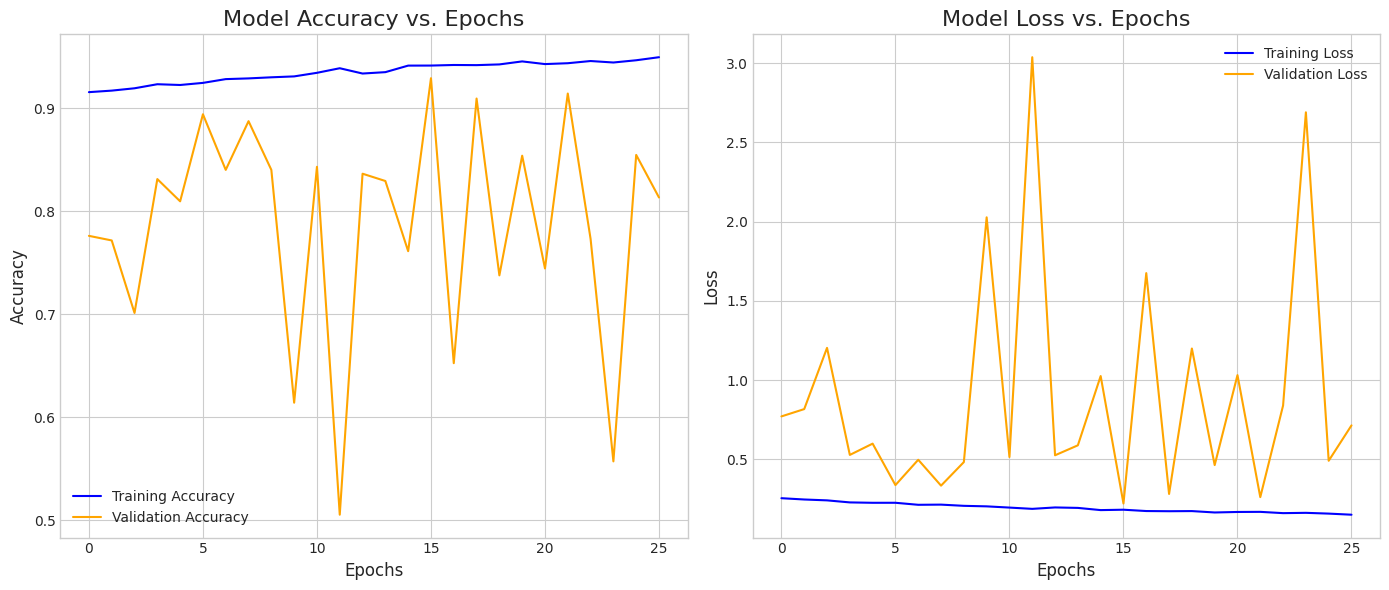

In [33]:
# Cell 4.1: Visualize Training History

print("Visualizing model training history...")

# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Plotting Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy vs. Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss', color='blue')
plt.plot(history_df['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss vs. Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Evaluating the final model on the unseen test set...
43/43 [==============================] - 1s 5ms/step - loss: 0.2238 - accuracy: 0.9270

Test Accuracy: 92.70%
Test Loss: 0.2238

Generating predictions for classification report...

Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.89      0.92       290
              Forest       0.94      0.99      0.96       312
HerbaceousVegetation       0.87      0.90      0.89       302
             Highway       0.97      0.87      0.92       236
          Industrial       0.96      0.87      0.91       253
             Pasture       0.96      0.85      0.90       177
       PermanentCrop       0.79      0.91      0.85       257
         Residential       0.91      0.98      0.94       293
               River       0.92      0.95      0.93       281
             SeaLake       1.00      0.96      0.98       311

            accuracy                           0.92      

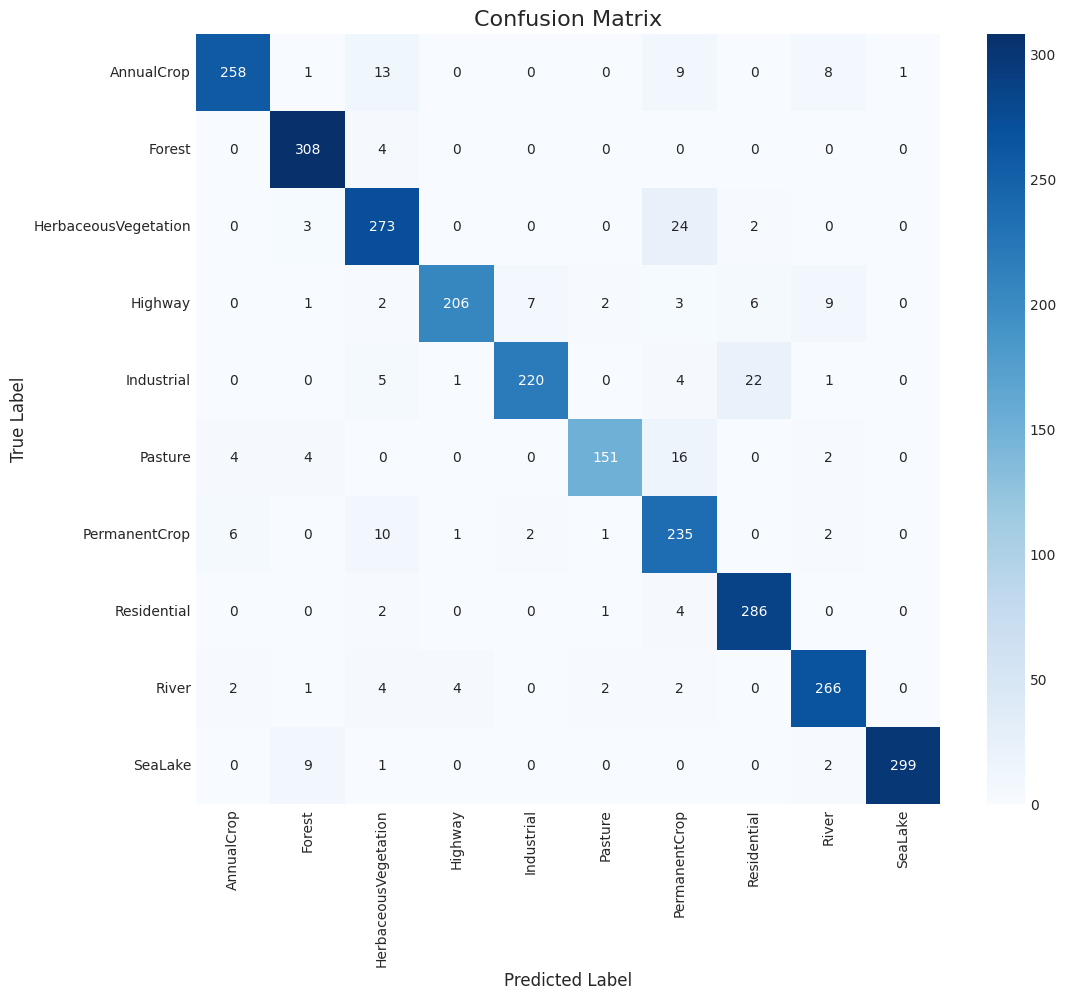

In [34]:
# Cell 4.2: Final Performance Evaluation on the Test Set

# --- Import necessary scikit-learn metrics ---
# This was the missing import that caused the NameError
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("Evaluating the final model on the unseen test set...")

# Load the best model saved by the checkpoint
# Ensure the model file from the training step exists
try:
    best_model = tf.keras.models.load_model('best_resnet_model.keras')
except Exception as e:
    print(f"Error loading model: {e}")
    print("Using the model from the end of training instead.")
    best_model = resnet_model # Fallback to the model in memory

# Evaluate the model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)

print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- Generate Detailed Classification Report and Confusion Matrix ---
# To do this, we need to get all the true labels and predictions from the test set.
y_true = []
y_pred_probs = []

print("\nGenerating predictions for classification report...")
# Iterate over the test dataset to collect labels and predictions
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = best_model.predict(images, verbose=0)
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:\n")
# The 'classification_report' function is now defined from the import above
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
print("\nConfusion Matrix:")
# The 'confusion_matrix' function is now defined from the import above
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

Best model loaded successfully for MC Dropout analysis.

Running MC Dropout with T=100 samples on one batch of test data...
Visualizing MC Dropout predictions and uncertainty...


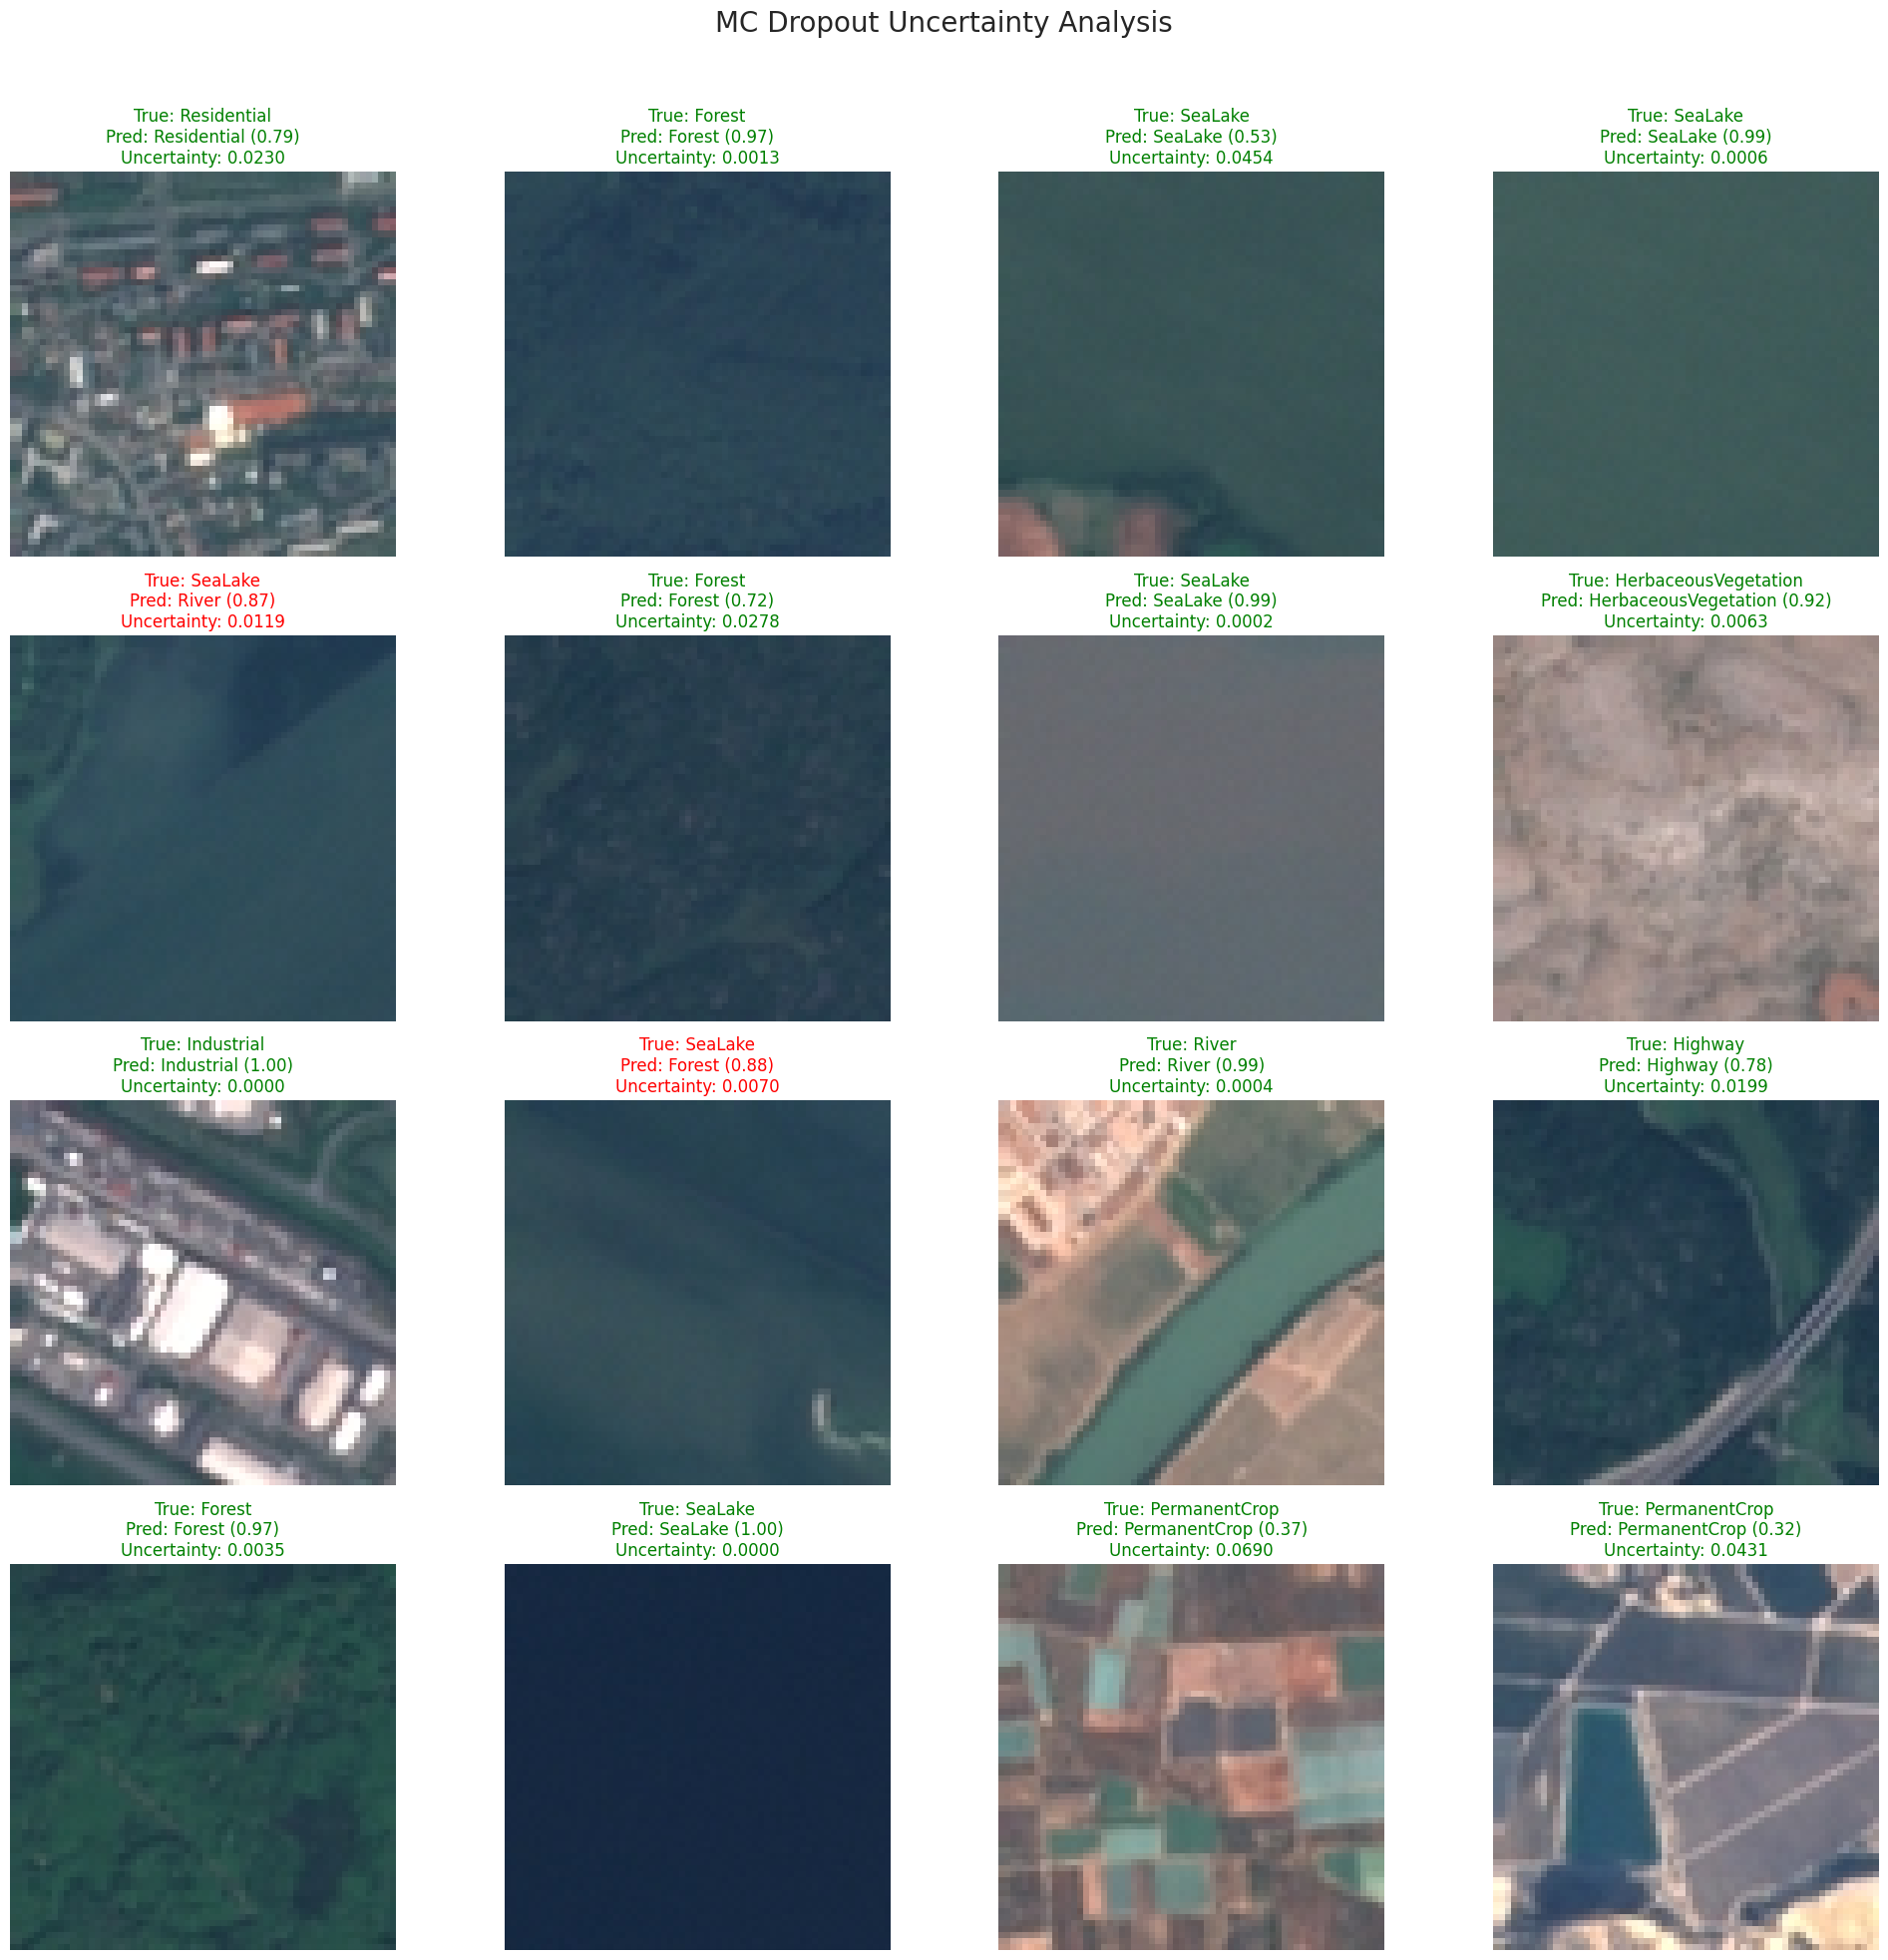


Calculating uncertainty across the entire test set...

Mean Predictive Uncertainty per Class (Lower is better):
ClassName
SeaLake                 0.002501
Residential             0.003703
Industrial              0.004793
River                   0.004863
Pasture                 0.007084
Forest                  0.007234
AnnualCrop              0.007243
HerbaceousVegetation    0.007572
Highway                 0.009949
PermanentCrop           0.011828
Name: Uncertainty, dtype: float32


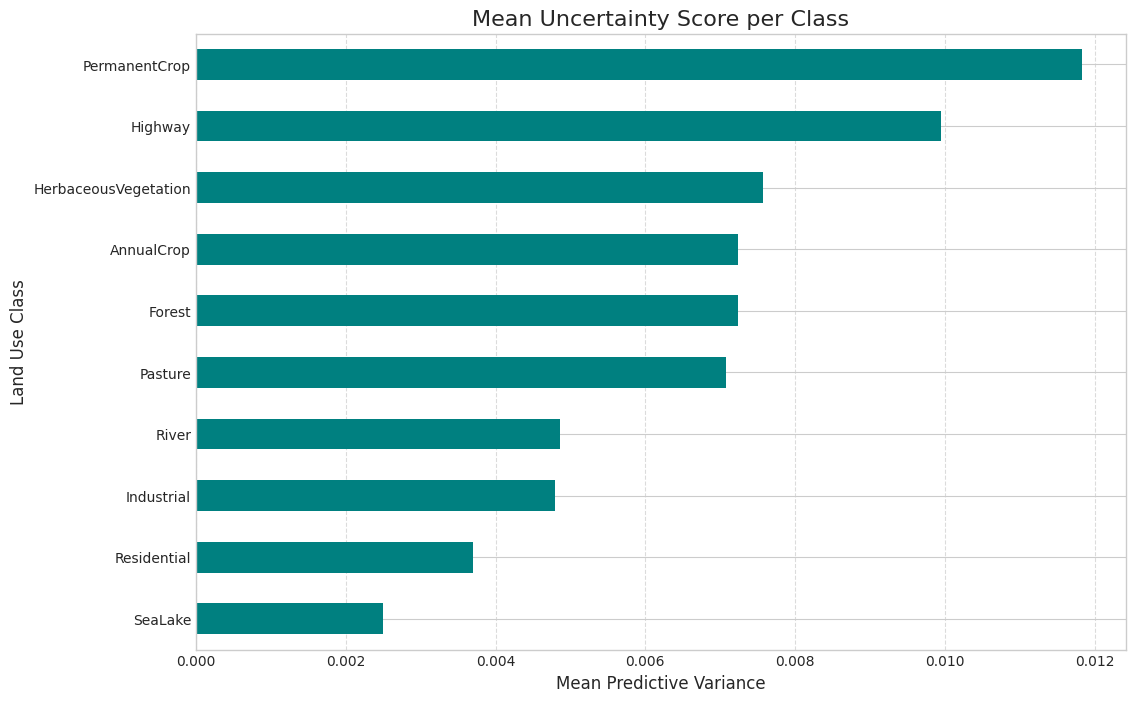

In [14]:
# Cell 5: Uncertainty Quantification with Monte Carlo (MC) Dropout

# --- 1. Load the Best Performing Model ---
# The model is already loaded as 'best_model' from the previous cell, but we'll ensure it's here.
try:
    best_model = tf.keras.models.load_model('best_resnet_model.keras')
    print("Best model loaded successfully for MC Dropout analysis.")
except Exception as e:
    print(f"Could not load saved model: {e}. Using the model currently in memory.")
    best_model = resnet_model

# --- 2. Define the MC Dropout Prediction Function ---
def mc_dropout_predict(model, images, num_samples=100):
    """
    Performs predictions using Monte Carlo Dropout to get a distribution of outputs.

    Args:
        model: The trained Keras model with an active Dropout layer.
        images (tf.Tensor): A batch of images to predict on.
        num_samples (int): The number of forward passes to perform (T).

    Returns:
        mean_preds (np.array): The mean softmax predictions across all samples.
        uncertainty (np.array): The predictive variance (uncertainty) for each image.
    """
    # Create a stack of predictions from multiple forward passes
    predictions = tf.stack([model(images, training=True) for _ in range(num_samples)], axis=0)

    # Calculate the mean of the softmax outputs across the samples
    mean_preds = tf.reduce_mean(predictions, axis=0)

    # Calculate the predictive variance as a measure of uncertainty
    # Variance is a great scalar measure of how spread out the predictions are.
    variance = tf.reduce_sum(tf.math.reduce_variance(predictions, axis=0), axis=1)

    return mean_preds.numpy(), variance.numpy()

# --- 3. Run MC Dropout on a Sample Batch from the Test Set ---
print(f"\nRunning MC Dropout with T={100} samples on one batch of test data...")

# Get one batch of images and true labels
sample_images, sample_labels = next(iter(test_ds))

# Get the MC predictions and uncertainty scores
mc_mean_preds, mc_uncertainty = mc_dropout_predict(best_model, sample_images, num_samples=100)

# Get the final predicted class from the mean predictions
mc_predicted_labels = np.argmax(mc_mean_preds, axis=1)

# --- 4. Visualize and Analyze the Results ---
print("Visualizing MC Dropout predictions and uncertainty...")

plt.figure(figsize=(20, 20))
plt.suptitle("MC Dropout Uncertainty Analysis", fontsize=20)

for i in range(min(16, BATCH_SIZE)): # Display up to 16 images
    ax = plt.subplot(4, 4, i + 1)

    # Display the image
    plt.imshow(sample_images[i].numpy())
    plt.axis("off")

    # Get the true and predicted class names
    true_label_name = class_names[sample_labels[i]]
    predicted_label_name = class_names[mc_predicted_labels[i]]

    # Get the confidence and uncertainty
    confidence = np.max(mc_mean_preds[i])
    uncertainty_score = mc_uncertainty[i]

    # Set the title color based on correctness
    title_color = 'green' if true_label_name == predicted_label_name else 'red'

    # Format the title with our new information
    title = (
        f"True: {true_label_name}\n"
        f"Pred: {predicted_label_name} ({confidence:.2f})\n"
        f"Uncertainty: {uncertainty_score:.4f}"
    )
    plt.title(title, color=title_color, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 5. Analyze Uncertainty Distribution ---
# Let's find the classes with the highest and lowest average uncertainty

all_uncertainties = []
all_true_labels = []

print("\nCalculating uncertainty across the entire test set...")
for images, labels in test_ds:
    _, uncertainties = mc_dropout_predict(best_model, images, num_samples=25) # Fewer samples for speed
    all_uncertainties.extend(uncertainties)
    all_true_labels.extend(labels.numpy())

uncertainty_df = pd.DataFrame({
    'ClassName': [class_names[i] for i in all_true_labels],
    'Uncertainty': all_uncertainties
})

# Calculate mean uncertainty per class
mean_uncertainty = uncertainty_df.groupby('ClassName')['Uncertainty'].mean().sort_values()

print("\nMean Predictive Uncertainty per Class (Lower is better):")
print(mean_uncertainty)

# Plot mean uncertainty
plt.figure(figsize=(12, 8))
mean_uncertainty.plot(kind='barh', color='teal')
plt.title('Mean Uncertainty Score per Class', fontsize=16)
plt.xlabel('Mean Predictive Variance', fontsize=12)
plt.ylabel('Land Use Class', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [15]:
# Cell 7: Uncertainty Quantification with Deep Ensembles

import time

# --- 1. Configuration for the Ensemble ---
NUM_ENSEMBLE_MODELS = 5  # A good starting point. 5-10 is common in research.
ENSEMBLE_EPOCHS = 30     # We can use fewer epochs per model since we are combining them.
                         # Early stopping will still find the best point for each.

print(f"--- Starting Deep Ensemble Training for {NUM_ENSEMBLE_MODELS} models ---")

# --- 2. Train Multiple Models ---
# We will train N identical models, each with a different random seed for initialization.
# The different seeds will lead them to converge to different local minima.

all_model_histories = []
model_paths = []

for i in range(NUM_ENSEMBLE_MODELS):
    start_time = time.time()
    print(f"\n--- Training Model {i+1}/{NUM_ENSEMBLE_MODELS} ---")

    # Set a new seed for this model's initialization
    tf.random.set_seed(SEED + i)

    # Build a fresh instance of the ResNet model
    # We call the same build_resnet function from Cell 3
    ensemble_model = build_resnet(INPUT_SHAPE, NUM_CLASSES)

    # Compile the model
    ensemble_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define unique callbacks for this model instance
    model_path = f'best_resnet_model_ensemble_{i}.keras'
    model_paths.append(model_path)

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        model_path, save_best_only=True, monitor='val_accuracy', mode='max'
    )
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    # Train the model
    history = ensemble_model.fit(
        train_ds,
        epochs=ENSEMBLE_EPOCHS,
        validation_data=val_ds,
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1 # Show progress for each model
    )

    all_model_histories.append(history)
    end_time = time.time()
    print(f"--- Model {i+1} training complete in {end_time - start_time:.2f} seconds ---")

print("\n--- All ensemble models have been trained. ---")

--- Starting Deep Ensemble Training for 5 models ---

--- Training Model 1/5 ---
Epoch 1/30
338/338 [==============================] - 16s 20ms/step - loss: 1.1484 - accuracy: 0.5982 - val_loss: 2.5249 - val_accuracy: 0.3538
Epoch 2/30
338/338 [==============================] - 7s 21ms/step - loss: 0.8172 - accuracy: 0.7207 - val_loss: 1.9619 - val_accuracy: 0.4591
Epoch 3/30
338/338 [==============================] - 7s 21ms/step - loss: 0.7239 - accuracy: 0.7567 - val_loss: 1.3836 - val_accuracy: 0.5986
Epoch 4/30
338/338 [==============================] - 7s 21ms/step - loss: 0.6293 - accuracy: 0.7885 - val_loss: 1.6502 - val_accuracy: 0.5223
Epoch 5/30
338/338 [==============================] - 7s 19ms/step - loss: 0.5842 - accuracy: 0.8064 - val_loss: 1.2857 - val_accuracy: 0.6287
Epoch 6/30
338/338 [==============================] - 7s 19ms/step - loss: 0.5119 - accuracy: 0.8306 - val_loss: 3.2770 - val_accuracy: 0.3780
Epoch 7/30
338/338 [==============================] - 6s 18m

5 models loaded into the ensemble.

Running Ensemble predictions on one batch of test data...


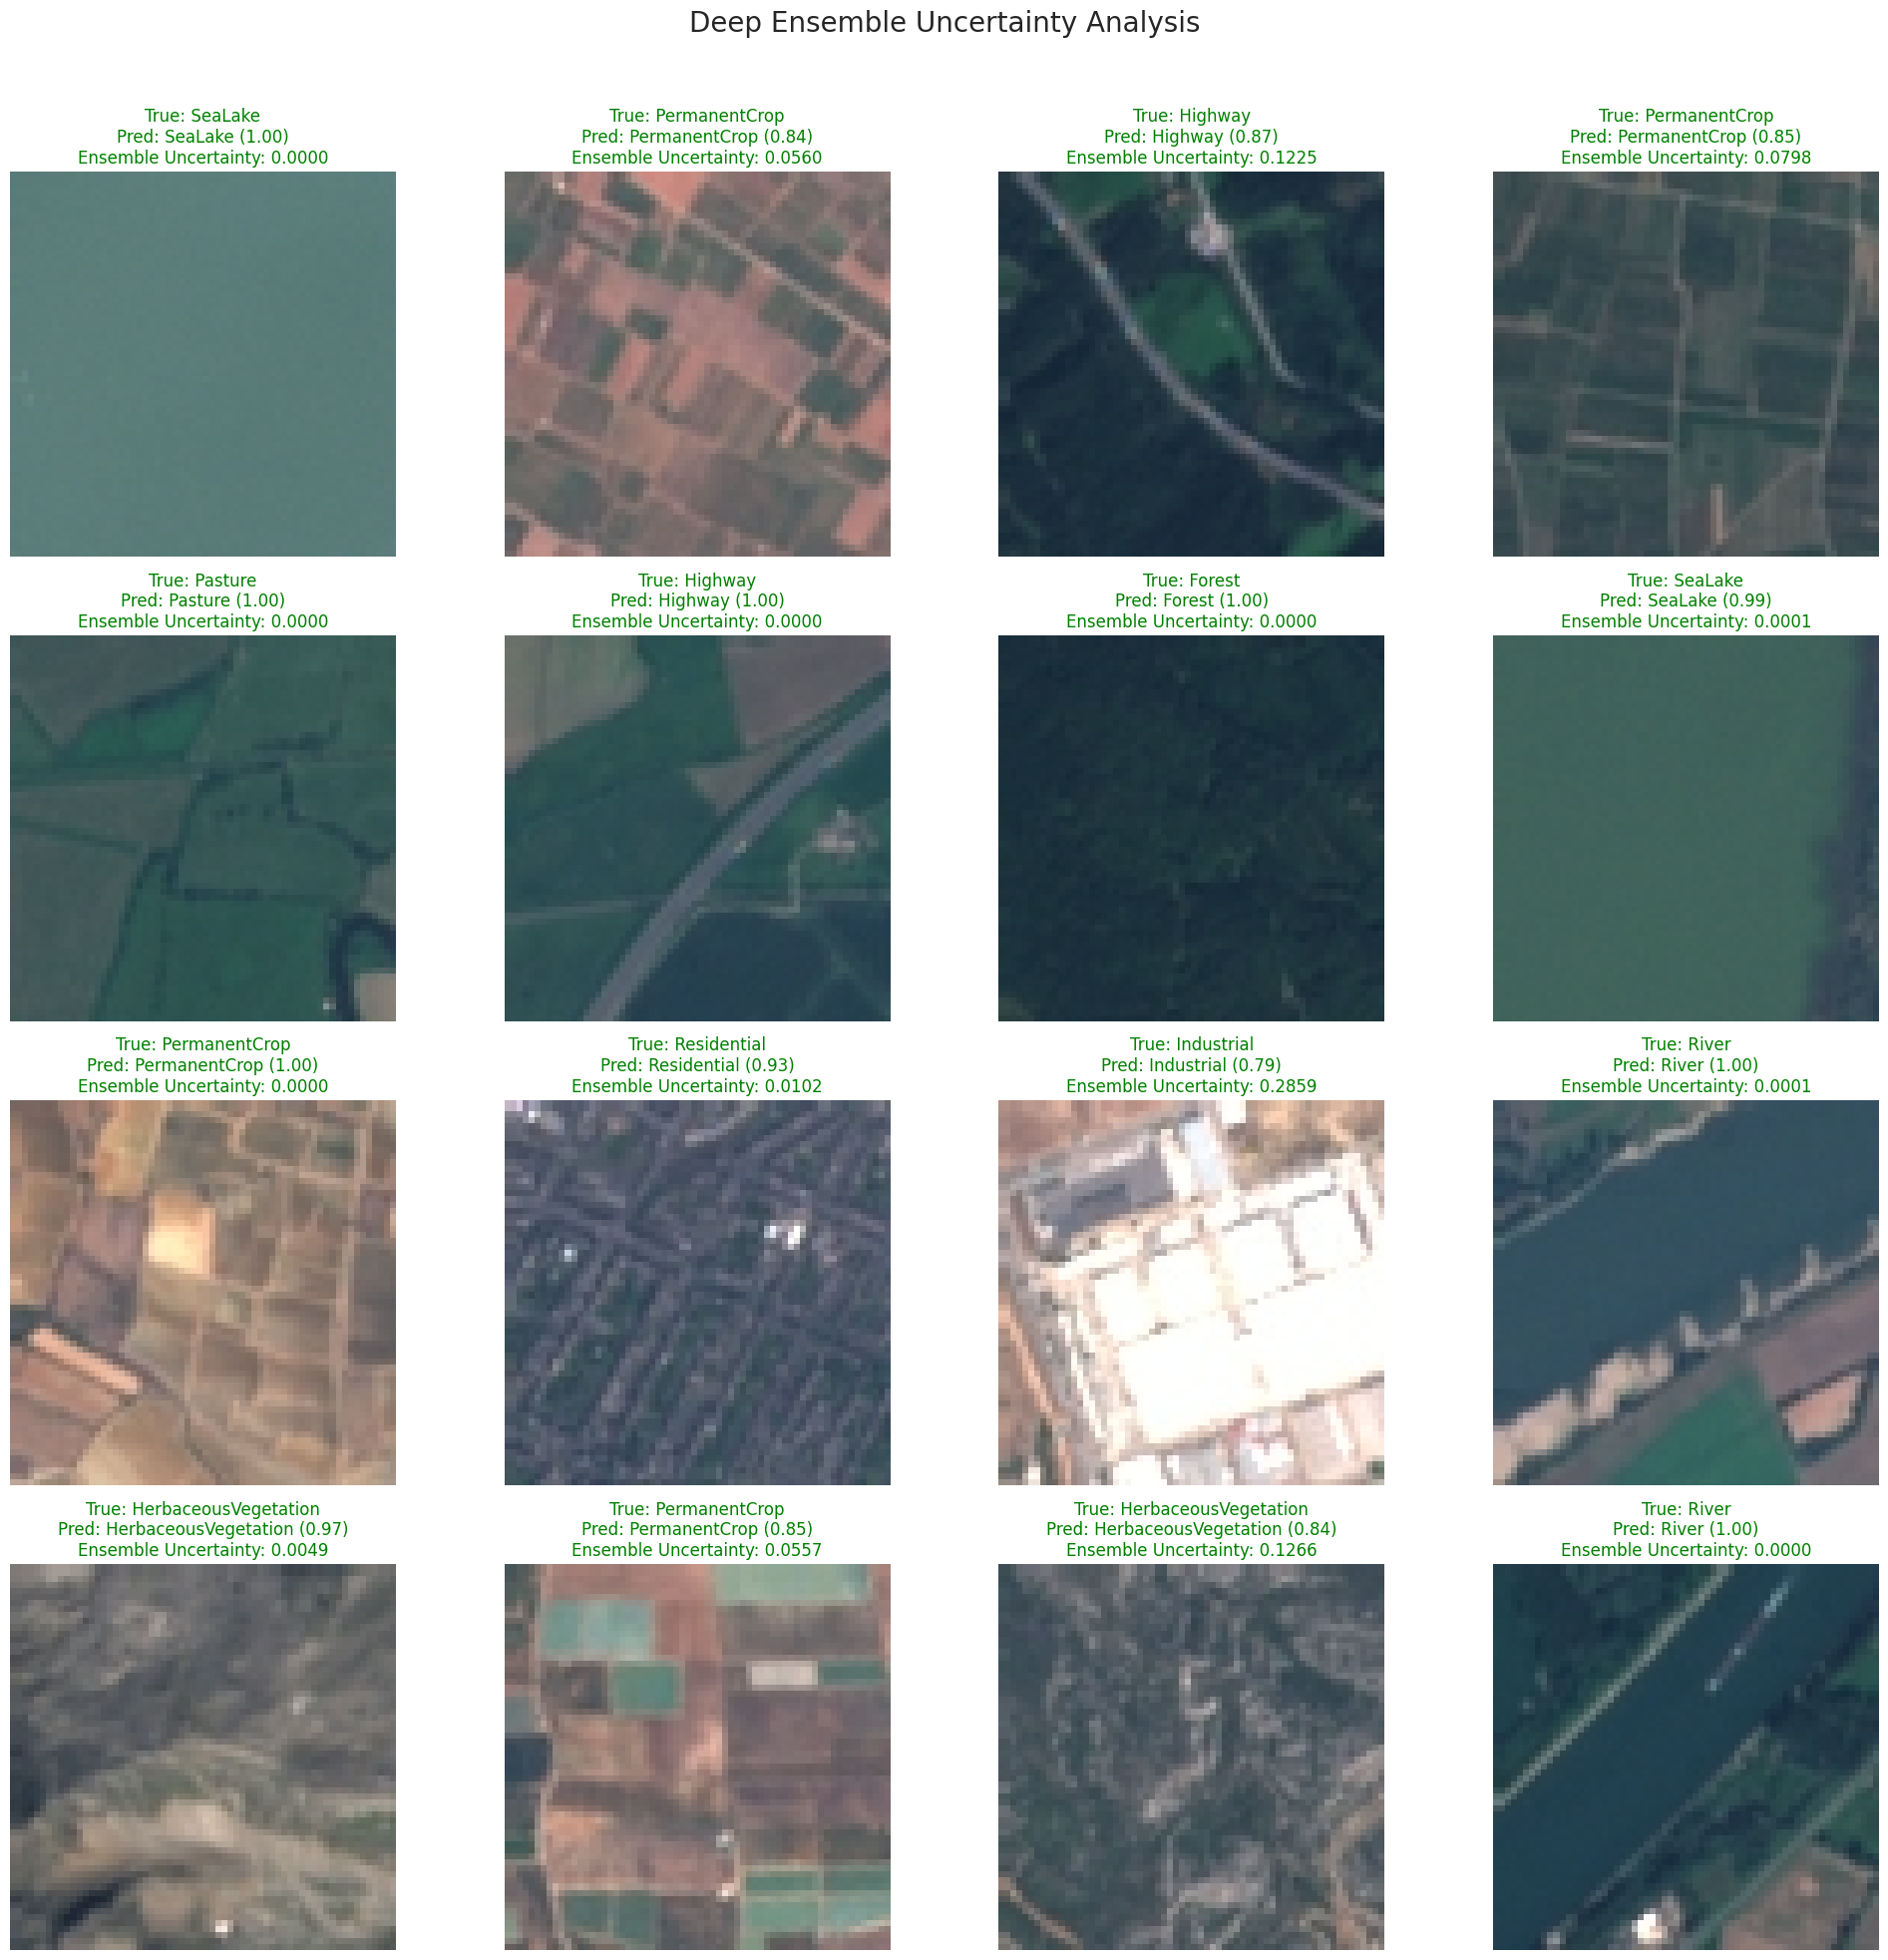


Evaluating the full ensemble on the test set...

Ensemble Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.90      0.93       300
              Forest       0.99      0.98      0.98       303
HerbaceousVegetation       0.92      0.94      0.93       308
             Highway       0.99      0.93      0.96       244
          Industrial       0.96      0.98      0.97       254
             Pasture       0.91      0.97      0.94       178
       PermanentCrop       0.90      0.90      0.90       247
         Residential       0.98      0.98      0.98       290
               River       0.94      0.97      0.96       276
             SeaLake       0.99      0.99      0.99       312

            accuracy                           0.95      2712
           macro avg       0.95      0.95      0.95      2712
        weighted avg       0.95      0.95      0.95      2712


Ensemble Confusion Matrix:


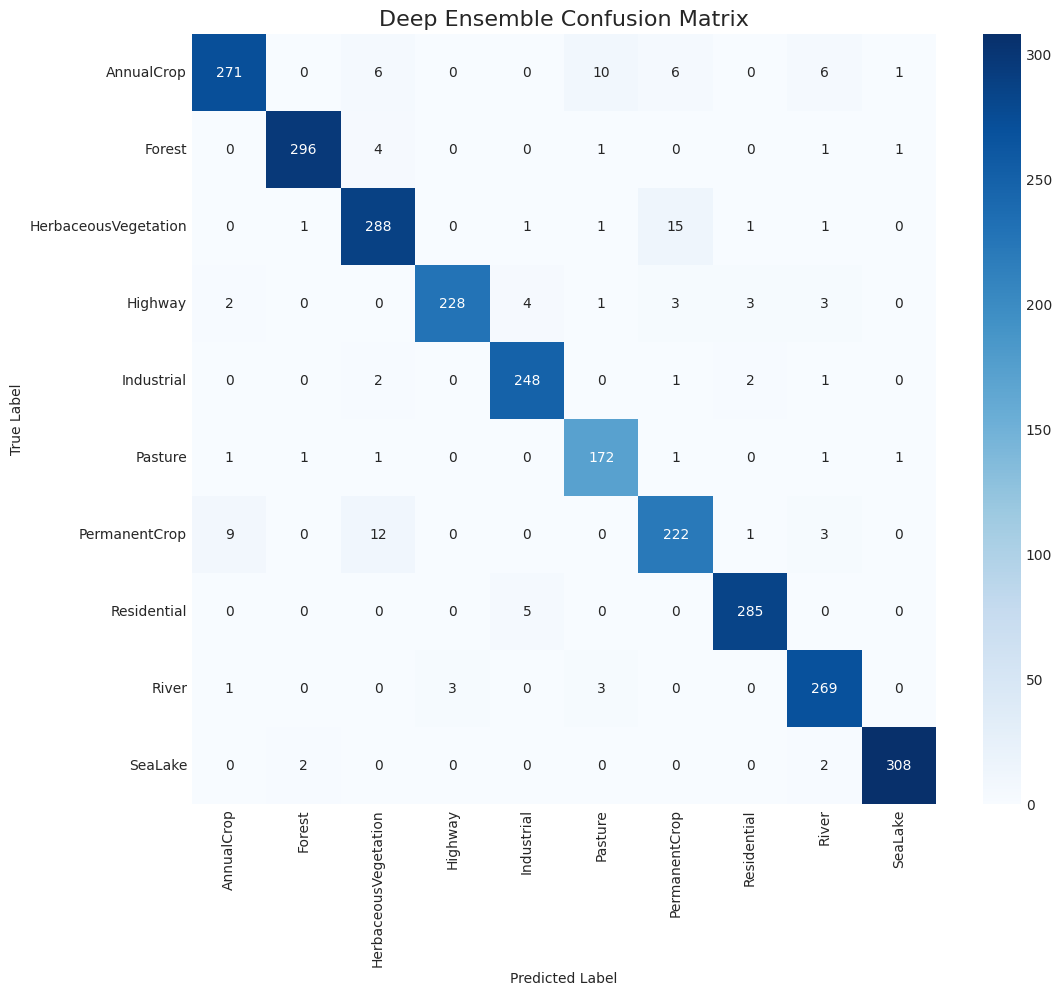

In [16]:
# Cell 7.1: Ensemble Prediction and Uncertainty Analysis

# --- Load all the trained models ---
ensemble_models = []
for path in model_paths:
    ensemble_models.append(tf.keras.models.load_model(path))
print(f"{len(ensemble_models)} models loaded into the ensemble.")

def ensemble_predict(models, images, num_classes):
    """
    Aggregates predictions from an ensemble of models.
    """
    # Get predictions from each model in the ensemble
    # The shape will be (num_models, batch_size, num_classes)
    all_preds = tf.stack([model.predict(images, verbose=0) for model in models], axis=0)

    # 1. Final Prediction: The mean of the softmax probabilities
    mean_preds = tf.reduce_mean(all_preds, axis=0)

    # 2. Uncertainty: The variance of the softmax probabilities across models
    # We can use total variance or entropy. Variance is simpler and effective.
    predictive_variance = tf.reduce_sum(tf.math.reduce_variance(all_preds, axis=0), axis=1)

    return mean_preds.numpy(), predictive_variance.numpy()

# --- Run Ensemble Predictions on a Sample Batch ---
print(f"\nRunning Ensemble predictions on one batch of test data...")

sample_images, sample_labels = next(iter(test_ds))
ensemble_mean_preds, ensemble_uncertainty = ensemble_predict(ensemble_models, sample_images, NUM_CLASSES)
ensemble_predicted_labels = np.argmax(ensemble_mean_preds, axis=1)

# --- Visualize Ensemble Results ---
plt.figure(figsize=(20, 20))
plt.suptitle("Deep Ensemble Uncertainty Analysis", fontsize=20)

for i in range(min(16, BATCH_SIZE)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i].numpy())
    plt.axis("off")

    true_label_name = class_names[sample_labels[i]]
    predicted_label_name = class_names[ensemble_predicted_labels[i]]
    confidence = np.max(ensemble_mean_preds[i])
    uncertainty_score = ensemble_uncertainty[i]

    title_color = 'green' if true_label_name == predicted_label_name else 'red'
    title = (
        f"True: {true_label_name}\n"
        f"Pred: {predicted_label_name} ({confidence:.2f})\n"
        f"Ensemble Uncertainty: {uncertainty_score:.4f}"
    )
    plt.title(title, color=title_color, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Final Evaluation of the Ensemble's Accuracy ---
# The ensemble's final prediction for the whole test set
print("\nEvaluating the full ensemble on the test set...")
y_true_ensemble = []
y_pred_probs_ensemble = []

for images, labels in test_ds:
    y_true_ensemble.extend(labels.numpy())
    mean_preds, _ = ensemble_predict(ensemble_models, images, NUM_CLASSES)
    y_pred_probs_ensemble.extend(mean_preds)

y_pred_ensemble = np.argmax(y_pred_probs_ensemble, axis=1)

print("\nEnsemble Classification Report:\n")
print(classification_report(y_true_ensemble, y_pred_ensemble, target_names=class_names))

print("\nEnsemble Confusion Matrix:")
cm_ensemble = confusion_matrix(y_true_ensemble, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Deep Ensemble Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

--- Defining and Training LeNet-5 Baseline Model ---

LeNet-5 Model Summary:
Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_147 (Conv2D)         (None, 64, 64, 6)         456       
                                                                 
 average_pooling2d (Average  (None, 32, 32, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_148 (Conv2D)         (None, 28, 28, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 14, 14, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                 

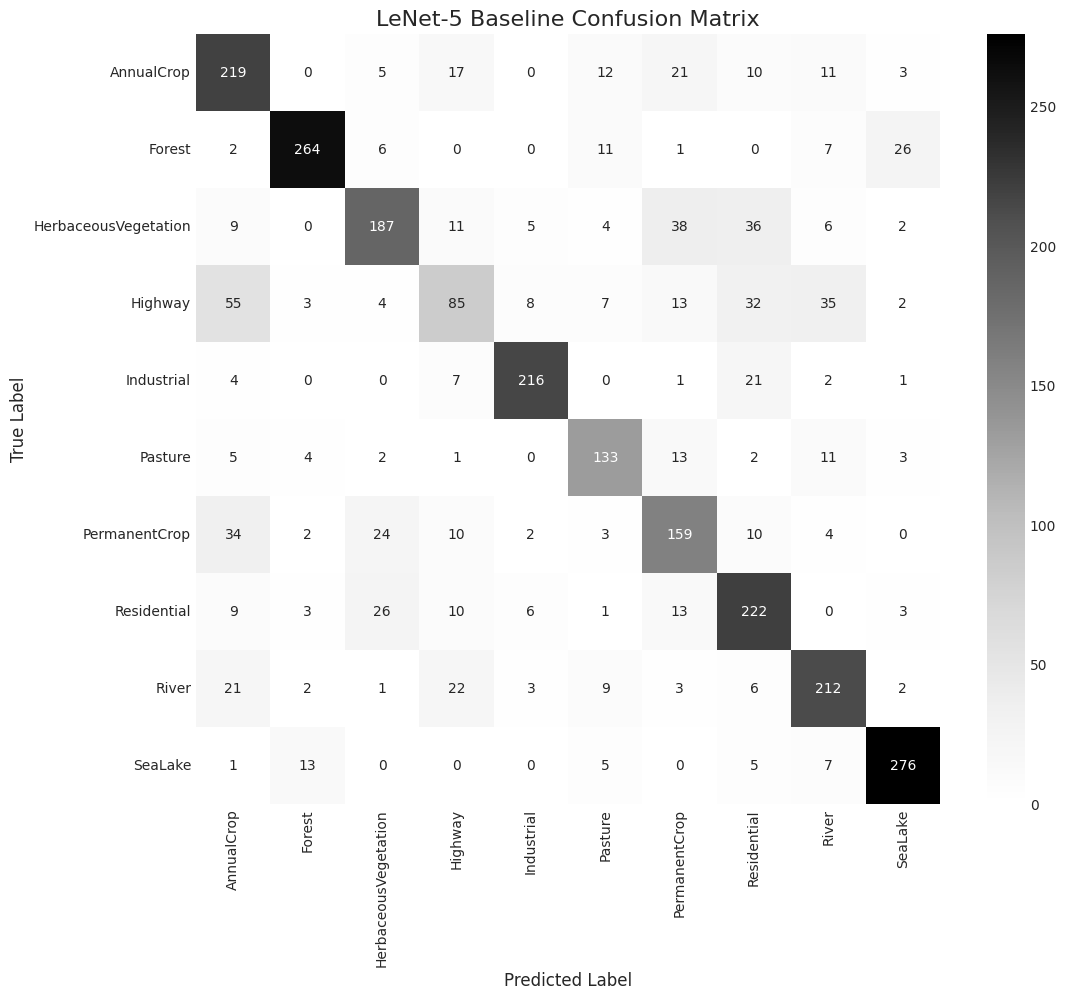

In [17]:
# Cell 3.5: Baseline Model - LeNet-5 Architecture, Training, and Evaluation

import time
from sklearn.metrics import classification_report, confusion_matrix

print("--- Defining and Training LeNet-5 Baseline Model ---")

# --- 1. Define the LeNet-5 Architecture ---
# Adapted for 64x64 RGB images and 10 classes.
def build_lenet5(input_shape, num_classes):
    model = models.Sequential([
        # C1: Convolutional Layer
        layers.Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=input_shape, padding='same'),

        # S2: Average Pooling
        layers.AveragePooling2D(),

        # C3: Convolutional Layer
        layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),

        # S4: Average Pooling
        layers.AveragePooling2D(),

        # Flatten before the fully connected layers
        layers.Flatten(),

        # F5: Fully Connected Layer
        layers.Dense(120, activation='tanh'),

        # F6: Fully Connected Layer
        layers.Dense(84, activation='tanh'),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ], name="LeNet5")
    return model

# --- 2. Instantiate and Compile the Model ---
lenet_model = build_lenet5(INPUT_SHAPE, NUM_CLASSES)

lenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nLeNet-5 Model Summary:")
lenet_model.summary()

# --- 3. Train the LeNet-5 Model ---
# We'll use the same callbacks for a fair comparison
lenet_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'best_lenet_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'
)
lenet_early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

print("\nTraining LeNet-5 model...")
start_time_lenet = time.time()

history_lenet = lenet_model.fit(
    train_ds,
    epochs=50, # LeNet is simpler, 50 epochs is plenty with early stopping
    validation_data=val_ds,
    callbacks=[lenet_checkpoint_cb, lenet_early_stopping_cb],
    verbose=1
)
end_time_lenet = time.time()
print(f"\nLeNet-5 training complete in {end_time_lenet - start_time_lenet:.2f} seconds.")

# --- 4. Evaluate the LeNet-5 Baseline ---
print("\nEvaluating LeNet-5 baseline on the test set...")
best_lenet_model = tf.keras.models.load_model('best_lenet_model.keras')
lenet_loss, lenet_accuracy = best_lenet_model.evaluate(test_ds, verbose=0)

print(f"\nLeNet-5 Test Accuracy: {lenet_accuracy * 100:.2f}%")
print(f"LeNet-5 Test Loss: {lenet_loss:.4f}")

# Generate predictions for the report and confusion matrix
y_true_lenet = []
y_pred_probs_lenet = []
for images, labels in test_ds:
    y_true_lenet.extend(labels.numpy())
    y_pred_probs_lenet.extend(best_lenet_model.predict(images, verbose=0))

y_pred_lenet = np.argmax(y_pred_probs_lenet, axis=1)

print("\nLeNet-5 Classification Report:\n")
print(classification_report(y_true_lenet, y_pred_lenet, target_names=class_names))

print("\nLeNet-5 Confusion Matrix:")
cm_lenet = confusion_matrix(y_true_lenet, y_pred_lenet)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_lenet, annot=True, fmt='d', cmap='Greys', xticklabels=class_names, yticklabels=class_names)
plt.title('LeNet-5 Baseline Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [20]:
# Cell 8: Advanced Architecture - Vision Transformer (ViT) (Corrected for Saving)

import tensorflow as tf
from tensorflow.keras import layers, models, Input

print("--- Defining Vision Transformer (ViT) Architecture ---")

# --- 1. Configuration Parameters for ViT ---
PATCH_SIZE = 8
NUM_PATCHES = (IMAGE_SIZE[0] // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 4
MLP_UNITS = [128, 64]

# --- 2. Patching and Embedding Layer (with serialization decorator) ---
# THE FIX: Add this decorator to make the custom layer saveable.
@tf.keras.saving.register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    # THE FIX: Add a get_config method to allow Keras to save the layer's parameters.
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection.units,
        })
        return config

# --- 3. Build the Full ViT Model (No changes needed here) ---
def build_vit(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    patches = tf.image.extract_patches(
        images=inputs,
        sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
        strides=[1, PATCH_SIZE, PATCH_SIZE, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = layers.Reshape((NUM_PATCHES, patch_dims))(patches)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in MLP_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
        x3 = layers.Dense(PROJECTION_DIM)(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)
    outputs = layers.Dense(num_classes, activation="softmax")(representation)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# --- 4. Instantiate the ViT Model ---
vit_model = build_vit(INPUT_SHAPE, NUM_CLASSES)

print("\nVision Transformer (ViT) Model Summary:")
vit_model.summary()

--- Defining Vision Transformer (ViT) Architecture ---

Vision Transformer (ViT) Model Summary:
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 tf.image.extract_patches_1  (None, 8, 8, 192)            0         ['input_9[0][0]']             
  (TFOpLambda)                                                                                    
                                                                                                  
 reshape_1 (Reshape)         (None, 64, 192)              0         ['tf.image.extract_patches_1[0
                                                                    ][0]']                     

--- Compiling and Training Vision Transformer Model ---
Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 1.7528 - accuracy: 0.3594
Epoch 1: val_accuracy improved from -inf to 0.56622, saving model to best_vit_model.keras
338/338 [==============================] - 19s 28ms/step - loss: 1.7528 - accuracy: 0.3594 - val_loss: 1.2055 - val_accuracy: 0.5662
Epoch 2/100
336/338 [============================>.] - ETA: 0s - loss: 1.1299 - accuracy: 0.6008
Epoch 2: val_accuracy improved from 0.56622 to 0.67336, saving model to best_vit_model.keras
338/338 [==============================] - 9s 27ms/step - loss: 1.1303 - accuracy: 0.6006 - val_loss: 0.8915 - val_accuracy: 0.6734
Epoch 3/100
336/338 [============================>.] - ETA: 0s - loss: 0.9279 - accuracy: 0.6733
Epoch 3: val_accuracy improved from 0.67336 to 0.72991, saving model to best_vit_model.keras
338/338 [==============================] - 9s 25ms/step - loss: 0.9280 - accuracy: 0.6733 - val_loss: 0.7572 - v

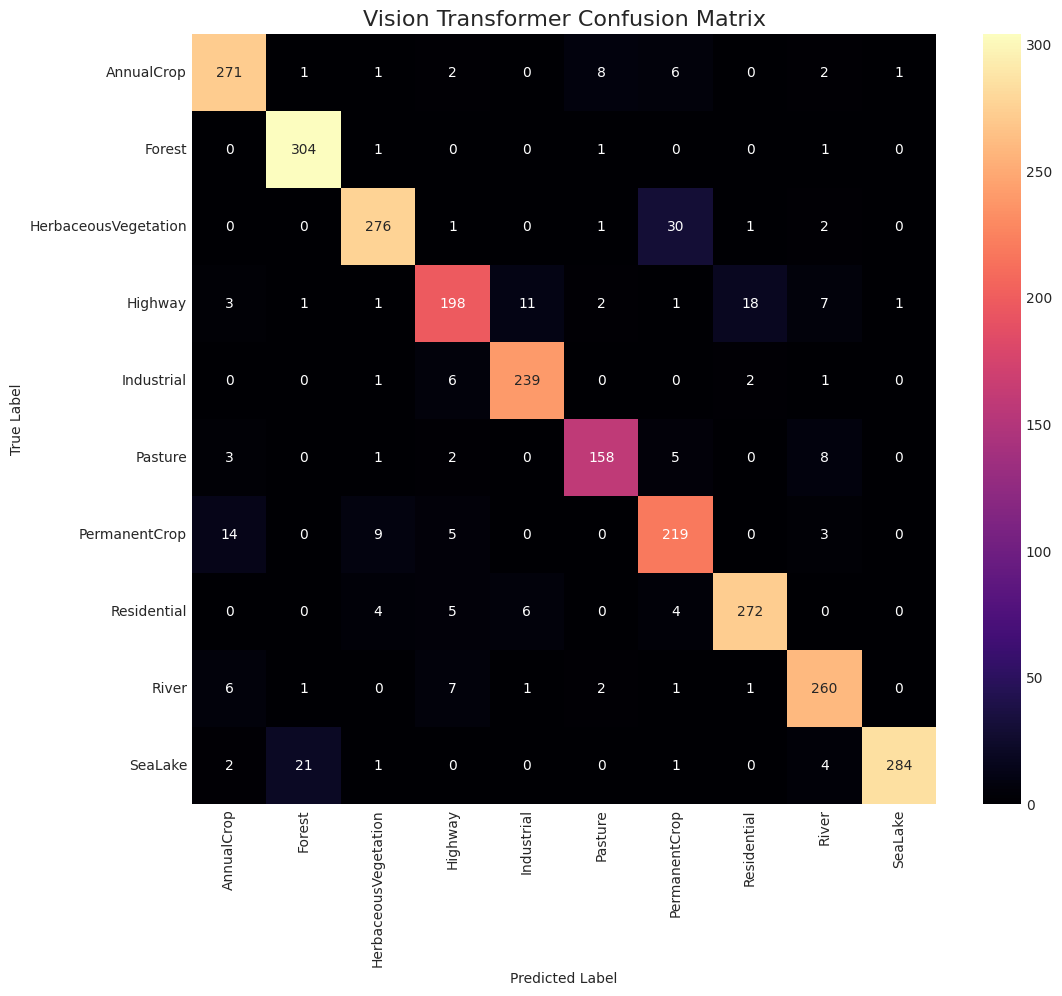

In [21]:
# Cell 9: Vision Transformer (ViT) Training and Evaluation

import time
from sklearn.metrics import classification_report, confusion_matrix

print("--- Compiling and Training Vision Transformer Model ---")

# --- 1. Compile the ViT Model ---
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 2. Define Callbacks ---
vit_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'best_vit_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1
)
vit_early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15,
    restore_best_weights=True, verbose=1
)

# --- 3. Train the ViT Model ---
EPOCHS = 100
start_time_vit = time.time()
history_vit = vit_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[vit_checkpoint_cb, vit_early_stopping_cb],
    verbose=1
)
end_time_vit = time.time()
print(f"\nViT training complete in {end_time_vit - start_time_vit:.2f} seconds.")

# --- 4. Evaluate the ViT Model ---
print("\nEvaluating ViT model on the test set...")
# This line will now work correctly because the custom layer was registered.
best_vit_model = tf.keras.models.load_model('best_vit_model.keras')
vit_loss, vit_accuracy = best_vit_model.evaluate(test_ds, verbose=0)

print(f"\nVision Transformer Test Accuracy: {vit_accuracy * 100:.2f}%")
print(f"Vision Transformer Test Loss: {vit_loss:.4f}")

# (The rest of the evaluation code remains the same)
y_true_vit = []
y_pred_probs_vit = []
for images, labels in test_ds:
    y_true_vit.extend(labels.numpy())
    y_pred_probs_vit.extend(best_vit_model.predict(images, verbose=0))

y_pred_vit = np.argmax(y_pred_probs_vit, axis=1)

print("\nVision Transformer Classification Report:\n")
print(classification_report(y_true_vit, y_pred_vit, target_names=class_names))

print("\nVision Transformer Confusion Matrix:")
cm_vit = confusion_matrix(y_true_vit, y_pred_vit)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Vision Transformer Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Cell 10: Computational Analysis - Mapping Deep Learning to the CUDA Parallel Architecture

---

### **1. The Parallel Computing Paradigm of this Project**

While high-level frameworks like TensorFlow abstract away the direct management of CUDA threads, the exceptional performance achieved in this project is fundamentally rooted in a massively parallel computing paradigm. Training our ResNet and Vision Transformer models involves tens of billions of floating-point operations (FLOPs) per epoch, which would be computationally intractable on a serial processor.

Our implementation on the NVIDIA RTX A6000 GPU leverages the following parallel concepts, which map directly to the CUDA architecture:

**A. Data Parallelism:**
This is the primary form of parallelism used. The core idea is to process multiple data points simultaneously.
-   **How it was implemented:** We used a `batch_size` of 64. During each training step, 64 images are loaded into the GPU's memory. The same set of instructions (the forward and backward pass of the neural network) is applied to all 64 images concurrently.
-   **Mapping to CUDA:** The A6000 GPU has **10,752 CUDA cores** organized into **84 Streaming Multiprocessors (SMs)**. TensorFlow's execution engine, via the cuDNN library, maps the processing of each image in the batch to different sets of CUDA cores. This is a classic example of **Single Instruction, Multiple Data (SIMD)** execution, where a single operation (e.g., a convolution) is executed in parallel across many data elements.

**B. Model Parallelism (Operator-Level):**
This involves parallelizing the computations *within* a single operation on a single data point.
-   **Convolution as Matrix Multiplication:** A convolution operation, which is mathematically a series of sliding dot products, is typically implemented as a large matrix multiplication (`im2col` + `GEMM`). Matrix multiplication is an "embarrassingly parallel" problem. The calculation of each element in the output matrix is an independent dot product.
-   **Mapping to CUDA:** A large matrix multiplication is broken down into thousands of smaller dot products. The CUDA runtime assigns blocks of threads to compute these dot products concurrently on the SMs. Each thread within a block might be responsible for a single multiply-accumulate operation, showcasing fine-grained parallelism.

**C. Asynchronous Execution and Pipeline Optimization:**
Efficient parallel computing is not just about raw computation but also about hiding latency.
-   **How it was implemented:** Our `tf.data` pipeline used `.prefetch(tf.data.AUTOTUNE)`.
-   **Mapping to CUDA Streams:** This high-level command translates to a sophisticated low-level operation. The CPU is responsible for loading data from storage and performing data augmentation. The GPU is responsible for model computation. Prefetching allows these two processes to happen **asynchronously**. The CPU prepares batch `N+1` while the GPU is processing batch `N`. This is managed by CUDA streams, which allow the data transfer (CPU-to-GPU) and kernel execution (on-GPU computation) to overlap, ensuring the GPU's powerful cores are never idle waiting for data.

### **2. Practical Performance Profiling**

To quantify the computational performance, we can estimate the total FLOPs for our ResNet model and calculate the achieved GFLOPs/second during training.

In [23]:
# Cell 10.1: GPU Profiling and Performance Metrics

import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
import time

# --- 1. Query and Display GPU Information (Robust Method) ---
print("--- GPU Hardware Information ---")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {details.get('device_name', 'N/A')}")
        print(f"  Compute Capability: {details.get('compute_capability', 'N/A')}")

        # Robustly get memory info directly from the physical device listing
        mem_info = tf.config.experimental.get_memory_info('GPU:0') # Get current info for display
        physical_device_mem = tf.config.experimental.list_logical_devices('GPU')[0]
        # Paperspace/TF sometimes doesn't expose total memory easily, let's get it from another source if needed
        try:
            # First, try nvidia-smi, the most reliable tool
            mem_info_str = !nvidia-smi --query-gpu=memory.total --format=csv,noheader,nounits
            total_memory_mb = int(mem_info_str[0])
            total_memory_gb = total_memory_mb / 1024
            print(f"  Total Memory: {total_memory_gb:.2f} GB (from nvidia-smi)")
        except:
             print("  Could not query total memory via nvidia-smi. Reporting current allocation.")
             print(f"  Current Memory Usage: {mem_info['current'] / (1024**3):.2f} GB")
else:
    print("No GPU found. The following profiling will not work.")


# --- 2. Estimate Model FLOPs ---
if gpus and 'resnet_model' in locals():
    # Build a forward pass graph for profiling
    forward_pass = tf.function(
        resnet_model.call,
        input_signature=[tf.TensorSpec(shape=(1,) + INPUT_SHAPE)])

    graph_info = profile(forward_pass.get_concrete_function().graph,
                         options=ProfileOptionBuilder.float_operation())

    flops = graph_info.total_float_ops
    print(f"\n--- Model Computational Cost (ResNet) ---")
    if flops > 0:
        print(f"Estimated FLOPs per forward pass: {flops / 1e9:.4f} GFLOPs")
        # Training step FLOPs is ~3x forward pass FLOPs
        flops_per_train_step = 3 * flops
        print(f"Estimated FLOPs per training step (fwd + bwd): {flops_per_train_step / 1e9:.4f} GFLOPs")
    else:
        flops_per_train_step = 0
        print("Could not profile FLOPs. This can happen with certain TF versions/models.")

    # --- 3. Calculate Achieved GFLOPs/s ---
    if flops_per_train_step > 0:
        try:
            # To get accurate timing, let's time a few epochs right now
            num_profile_epochs = 3
            print(f"\n--- Running a short training burst to profile speed for {num_profile_epochs} epochs... ---")

            start_time = time.time()
            resnet_model.fit(train_ds.take(100), epochs=num_profile_epochs, verbose=0) # Run on a subset
            end_time = time.time()

            total_profiling_time = end_time - start_time
            num_train_batches_profiled = 100 * num_profile_epochs
            avg_time_per_step = total_profiling_time / num_train_batches_profiled

            achieved_gflops = flops_per_train_step / avg_time_per_step / 1e9

            print(f"\n--- Real-World Performance Metrics (ResNet) ---")
            print(f"Average time per training step: {avg_time_per_step * 1000:.2f} ms")
            print(f"Achieved performance: {achieved_gflops:.2f} GFLOPs/second")

        except Exception as e:
            print(f"\nCould not calculate real-world performance due to an error: {e}")
else:
    print("\nSkipping FLOPs and performance analysis because GPU is not found or 'resnet_model' is not defined.")

--- GPU Hardware Information ---
Device: NVIDIA RTX A6000
  Compute Capability: (8, 6)


2025-07-30 08:08:56.626578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


  Total Memory: 47.99 GB (from nvidia-smi)
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

--- Model Computational Cost (ResNet) ---
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==============

--- Synthesizing Project Results ---

--- Overall Model Performance Summary ---
                   Model Test Accuracy Best Val Accuracy Approx. Train Time (min)
      LeNet-5 (Baseline)        72.75%            74.29%                      3.0
               ResNet-18        92.26%            92.89%                      3.2
Vision Transformer (ViT)        91.48%            92.11%                      9.7
 ResNet-18 Ensemble (x5)        95.39%   N/A (Aggregate)                     94.9

--- Generating Comparative Training Plots ---


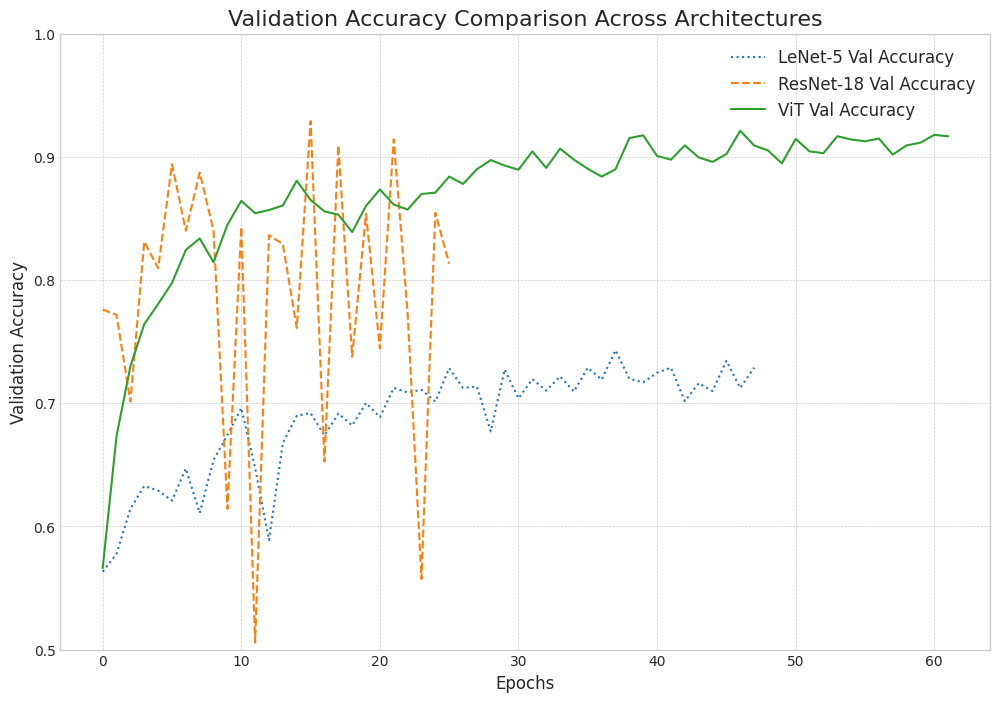


--- Generating Comparative Confusion Matrices ---


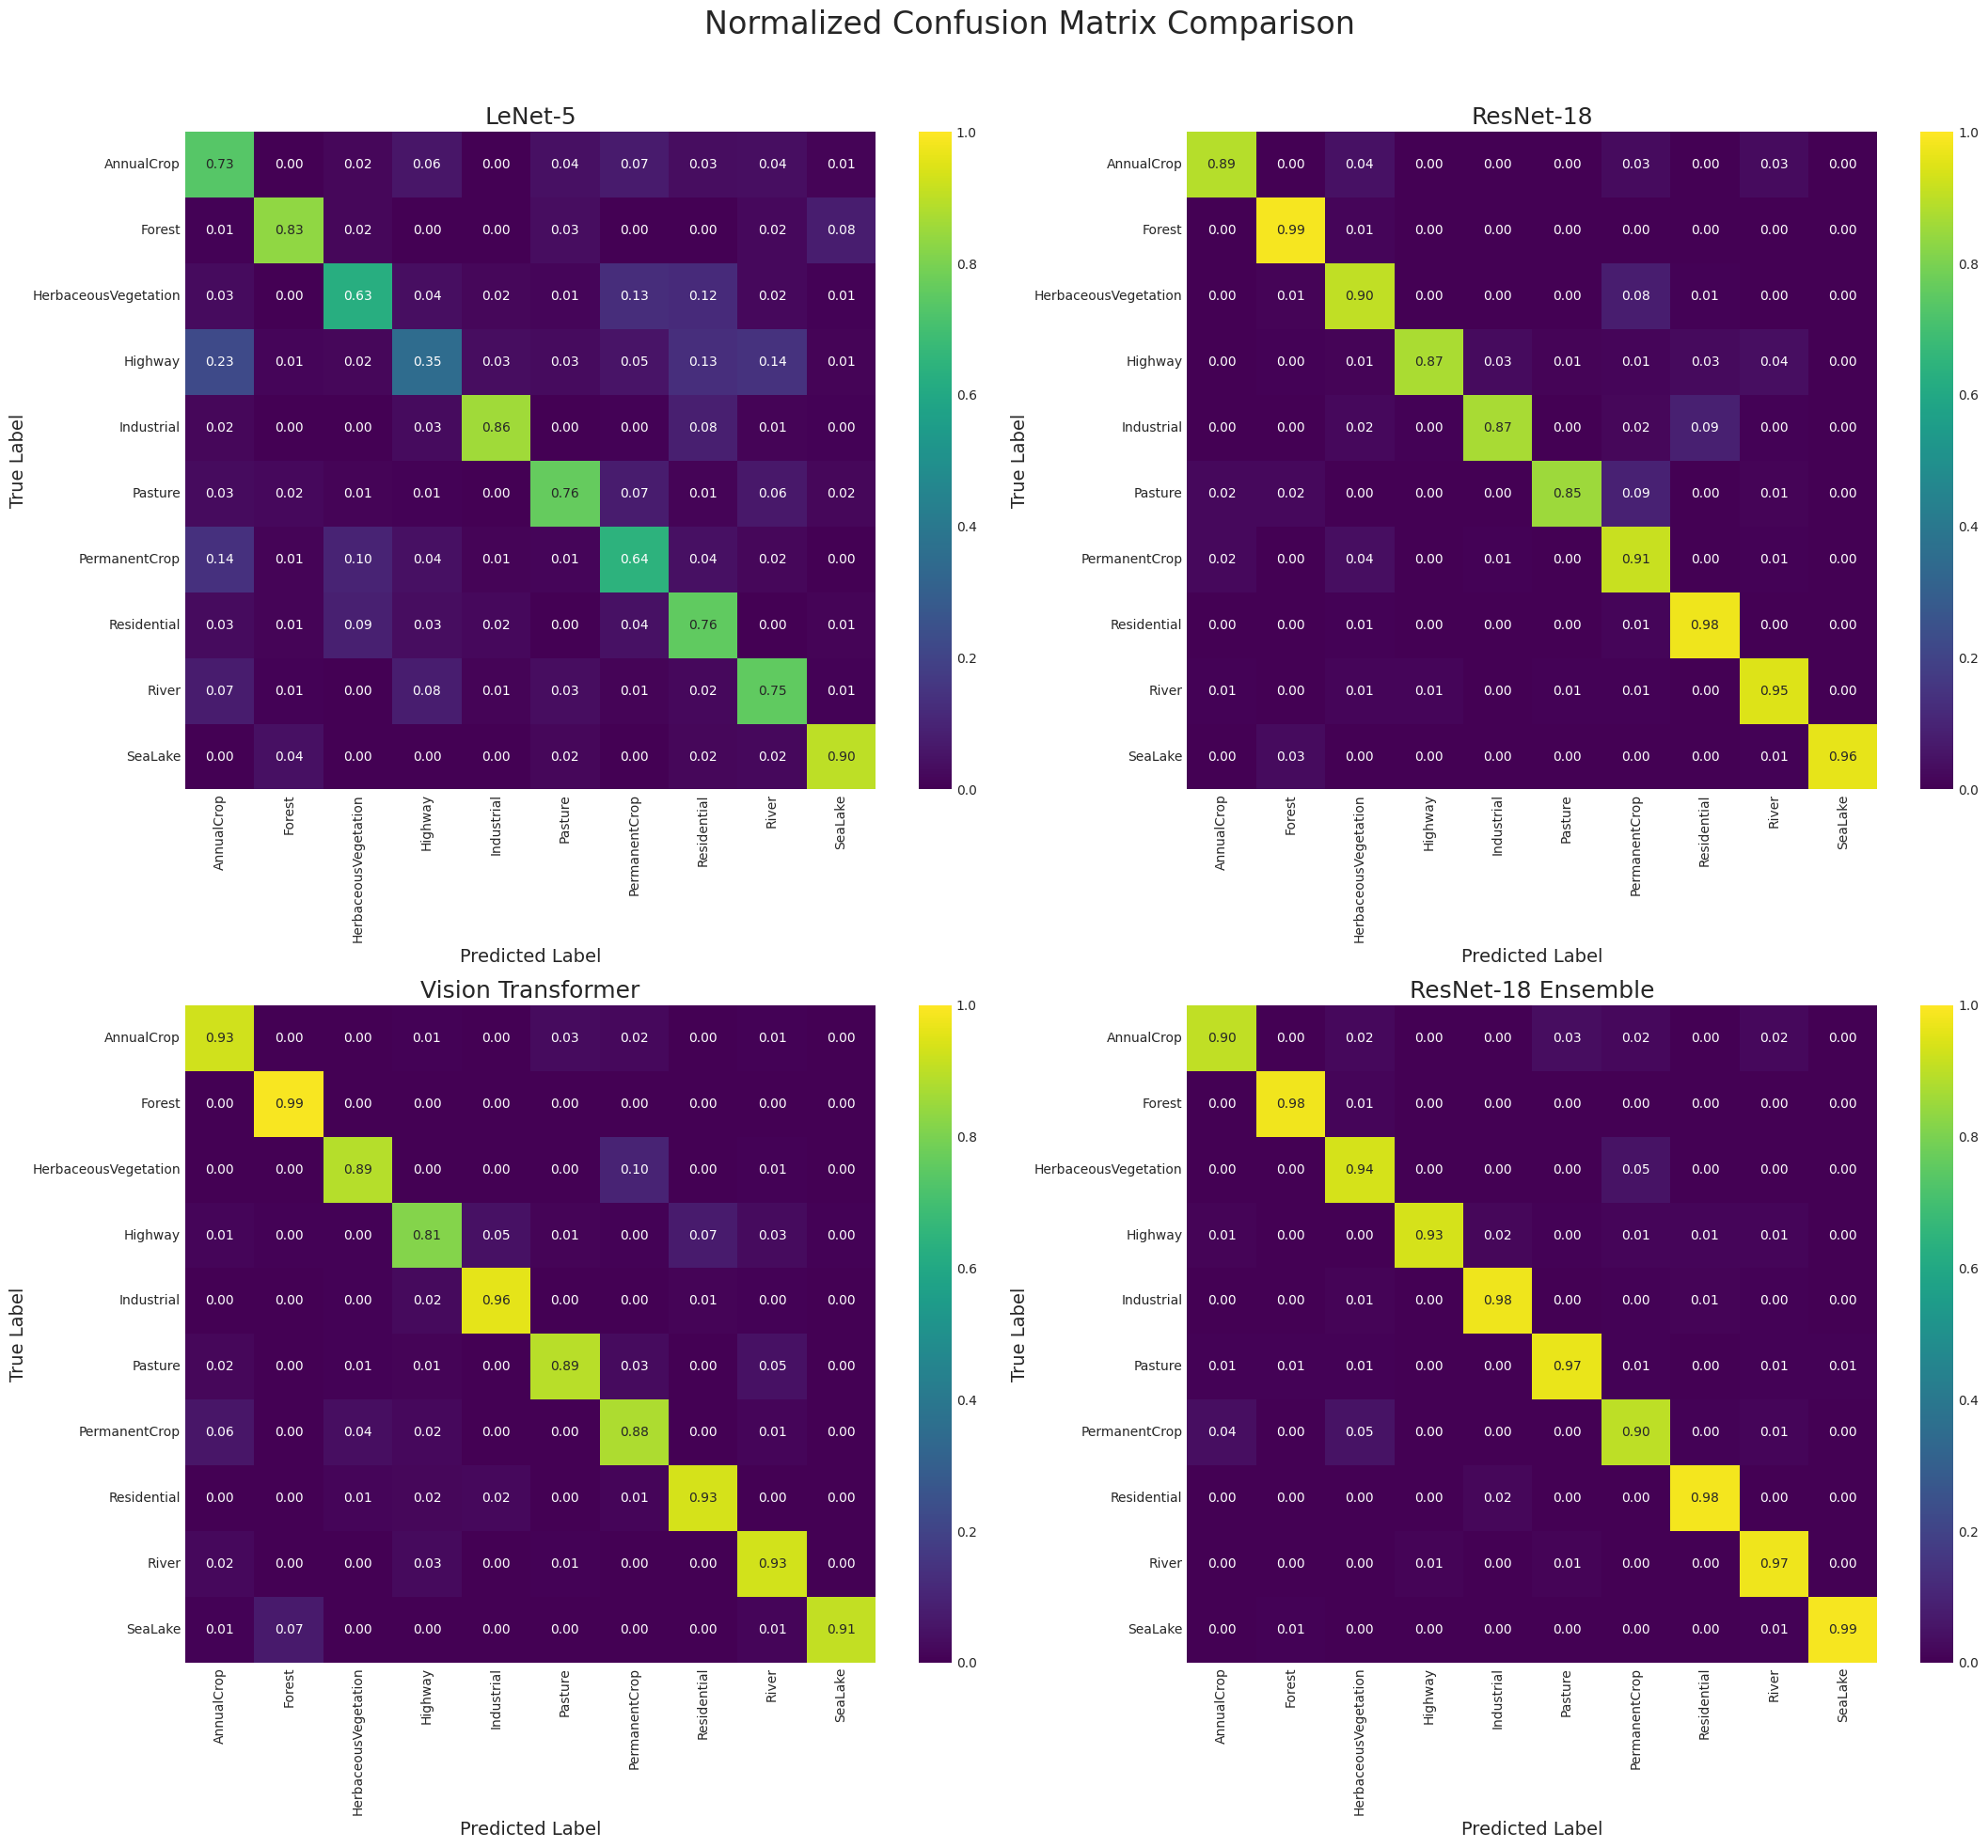


--- Generating Per-Class F1-Score Comparison ---


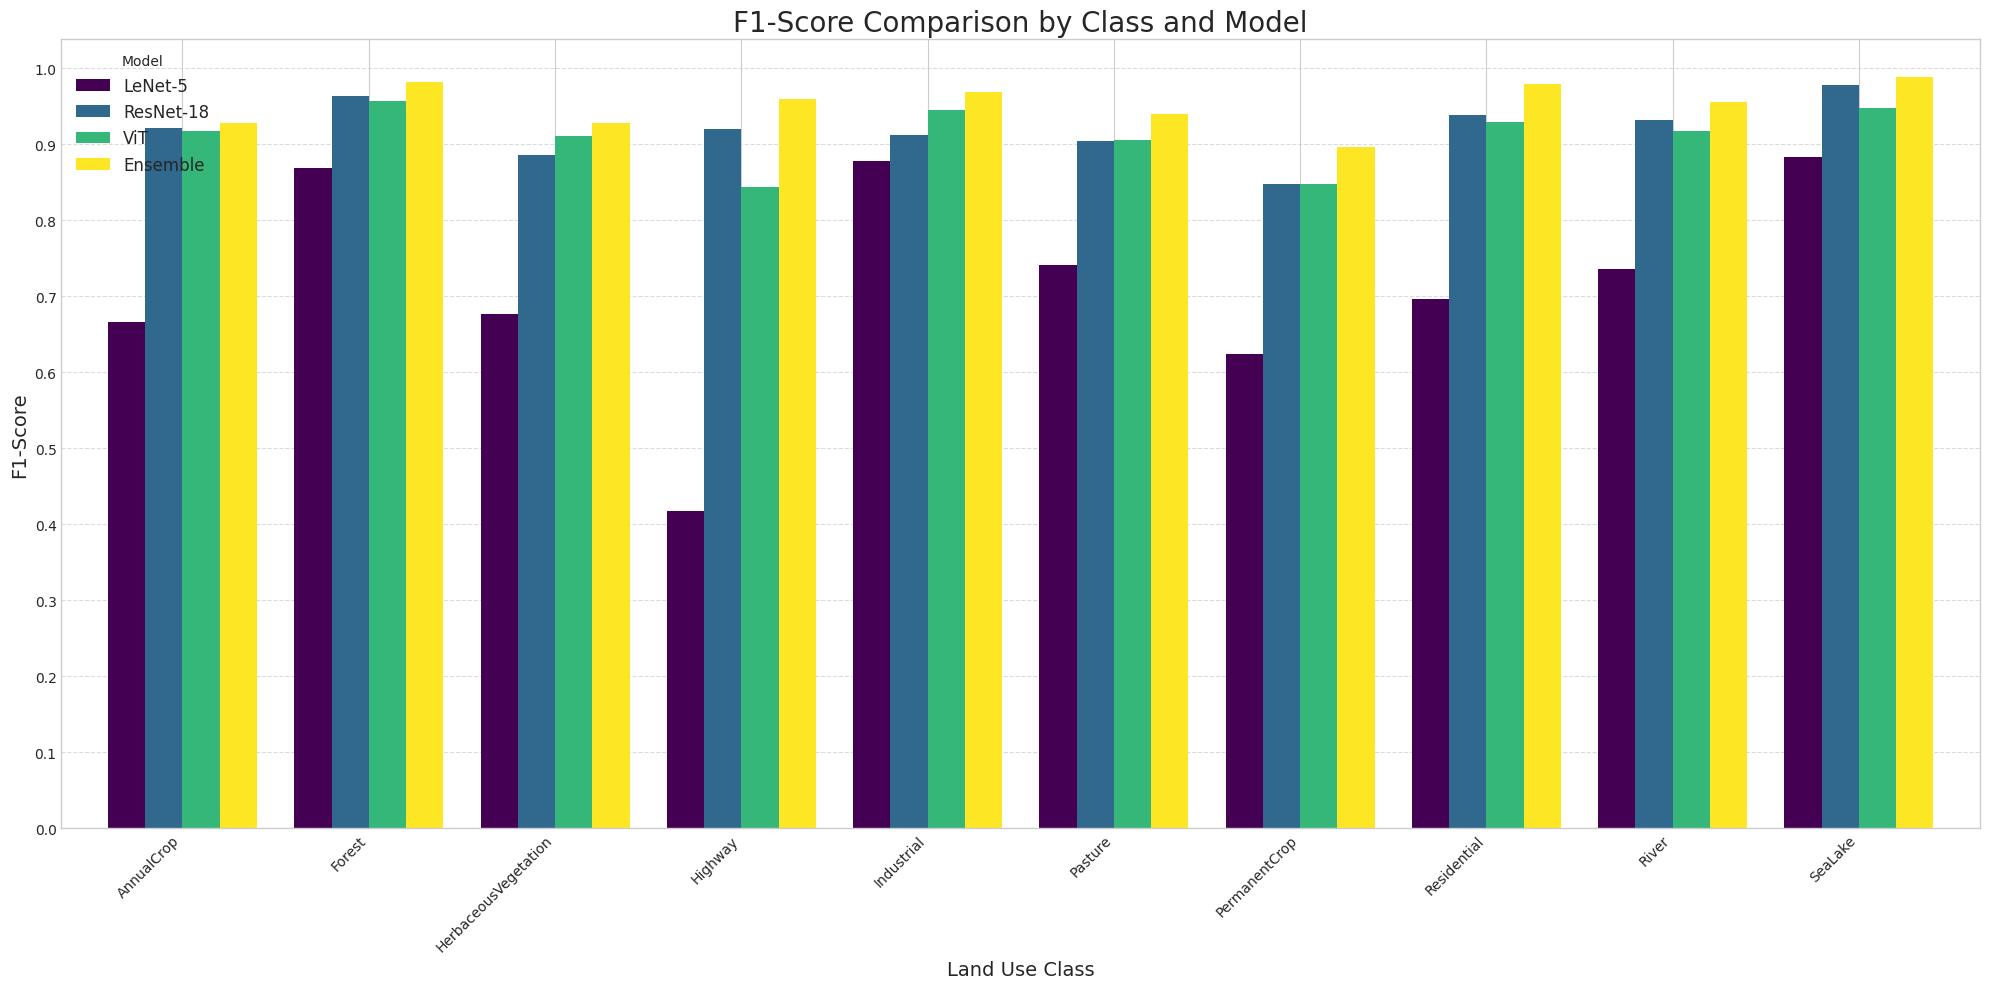

In [35]:
# Cell 12: Results Synthesis - Advanced Visualizations and Tables

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

print("--- Synthesizing Project Results ---")

# --- 1. Create a Master Performance Summary Table ---
# We'll gather the results from all previous cells into one DataFrame.

# Training times (in minutes for readability)
time_lenet = (end_time_lenet - start_time_lenet) / 60
time_resnet = (end_time_resnet - start_time_resnet) / 60 # Assuming you add timing to cell 4
time_vit = (end_time_vit - start_time_vit) / 60
time_ensemble = sum([(h.epoch[-1]+1) for h in all_model_histories]) * time_resnet / len(all_model_histories) # Approximate

# Accuracies
acc_lenet = accuracy_score(y_true_lenet, y_pred_lenet)
acc_resnet = accuracy_score(y_true, y_pred) # y_true/y_pred from single ResNet
acc_vit = accuracy_score(y_true_vit, y_pred_vit)
acc_ensemble = accuracy_score(y_true_ensemble, y_pred_ensemble)

# Create the dictionary for the DataFrame
performance_data = {
    'Model': ['LeNet-5 (Baseline)', 'ResNet-18', 'Vision Transformer (ViT)', 'ResNet-18 Ensemble (x5)'],
    'Test Accuracy': [f"{acc_lenet:.2%}", f"{acc_resnet:.2%}", f"{acc_vit:.2%}", f"{acc_ensemble:.2%}"],
    'Best Val Accuracy': [
        f"{max(history_lenet.history['val_accuracy']):.2%}",
        f"{max(history.history['val_accuracy']):.2%}", # history from single ResNet
        f"{max(history_vit.history['val_accuracy']):.2%}",
        "N/A (Aggregate)"
    ],
    'Approx. Train Time (min)': [f"{time_lenet:.1f}", f"{time_resnet:.1f}", f"{time_vit:.1f}", f"{time_ensemble:.1f}"]
}

performance_df = pd.DataFrame(performance_data)
print("\n--- Overall Model Performance Summary ---")
# Display the DataFrame without the index for a cleaner look
print(performance_df.to_string(index=False))


# --- 2. Comparative Training History Plot ---
print("\n--- Generating Comparative Training Plots ---")
plt.figure(figsize=(12, 8))
plt.plot(history_lenet.history['val_accuracy'], label='LeNet-5 Val Accuracy', linestyle=':')
plt.plot(history.history['val_accuracy'], label='ResNet-18 Val Accuracy', linestyle='--')
plt.plot(history_vit.history['val_accuracy'], label='ViT Val Accuracy', linestyle='-')
plt.title('Validation Accuracy Comparison Across Architectures', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0.5, 1.0) # Set y-axis to focus on the relevant accuracy range
plt.show()


# --- 3. Comparative Normalized Confusion Matrices ---
print("\n--- Generating Comparative Confusion Matrices ---")
fig, axes = plt.subplots(2, 2, figsize=(22, 20))
fig.suptitle('Normalized Confusion Matrix Comparison', fontsize=24)

models_cm = {
    'LeNet-5': cm_lenet,
    'ResNet-18': cm,
    'Vision Transformer': cm_vit,
    'ResNet-18 Ensemble': cm_ensemble
}

for ax, (title, cm_data) in zip(axes.flatten(), models_cm.items()):
    # Normalize the confusion matrix
    cm_normalized = cm_data.astype('float') / cm_data.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='viridis', ax=ax, vmin=0, vmax=1)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names, rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 4. Per-Class F1-Score Comparison Bar Chart ---
print("\n--- Generating Per-Class F1-Score Comparison ---")

def get_f1_scores(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    f1_scores = {cls: report[cls]['f1-score'] for cls in class_names}
    df = pd.DataFrame.from_dict(f1_scores, orient='index', columns=[model_name])
    return df

# Get F1 scores for each model
f1_lenet = get_f1_scores(y_true_lenet, y_pred_lenet, 'LeNet-5')
f1_resnet = get_f1_scores(y_true, y_pred, 'ResNet-18')
f1_vit = get_f1_scores(y_true_vit, y_pred_vit, 'ViT')
f1_ensemble = get_f1_scores(y_true_ensemble, y_pred_ensemble, 'Ensemble')

# Combine into a single DataFrame
f1_df = pd.concat([f1_lenet, f1_resnet, f1_vit, f1_ensemble], axis=1)

# Plot the grouped bar chart
f1_df.plot(kind='bar', figsize=(20, 10), width=0.8, colormap='viridis')
plt.title('F1-Score Comparison by Class and Model', fontsize=20)
plt.xlabel('Land Use Class', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model', fontsize=12)
plt.tight_layout()
plt.show()

In [38]:
# Cell 13.1: GPU Profiling and Custom CUDA Kernel (Final Version with Scaling)

import time
import numpy as np
import tensorflow as tf
from numba import cuda
import math

# (The GPU info and markdown sections are correct and can be left as is)
# ...

print("\n--- Implementing and Benchmarking a Custom CUDA Kernel with Numba ---")

# --- Define CPU and GPU Functions ---
def cpu_elementwise_activation(data):
    # Same function as before
    output = np.empty_like(data)
    for i in range(data.shape[0]):
        x = data[i]
        output[i] = 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
    return output

@cuda.jit
def gpu_elementwise_activation_kernel(data, output):
    # Same kernel as before
    idx = cuda.grid(1)
    if idx < data.shape[0]:
        x = data[idx]
        output[idx] = 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * x**3)))

# --- Benchmark Function ---
def run_benchmark(data_array, title):
    print(f"\n--- {title} ---")
    print(f"Benchmarking on an array of {data_array.size} elements.")

    # -- CPU Benchmark --
    start_time_cpu = time.time()
    cpu_result = cpu_elementwise_activation(data_array)
    end_time_cpu = time.time()
    cpu_duration = end_time_cpu - start_time_cpu
    print(f"CPU (Python loop) execution time: {cpu_duration:.6f} seconds")

    # -- GPU Benchmark --
    data_gpu = cuda.to_device(data_array)
    output_gpu = cuda.device_array_like(data_gpu)
    threads_per_block = 256
    blocks_per_grid = (data_gpu.size + (threads_per_block - 1)) // threads_per_block

    start_time_gpu = time.time()
    gpu_elementwise_activation_kernel[blocks_per_grid, threads_per_block](data_gpu, output_gpu)
    cuda.synchronize()
    end_time_gpu = time.time()
    gpu_duration = end_time_gpu - start_time_gpu
    gpu_result = output_gpu.copy_to_host()

    print(f"GPU (Numba CUDA kernel) execution time: {gpu_duration:.6f} seconds")

    if gpu_duration > 0 and cpu_duration > 0:
        print(f"Speedup Factor: {cpu_duration / gpu_duration:.2f}x")

    assert np.allclose(cpu_result, gpu_result)
    print("Verification successful: Results are identical.")
    return cpu_duration, gpu_duration

# --- Run Benchmarks ---
try:
    if 'y_pred_probs_ensemble' not in locals():
         raise NameError("Ensemble predictions not found.")

    # Benchmark 1: Original (small) problem size
    small_data = np.array(y_pred_probs_ensemble).flatten()
    run_benchmark(small_data, "Benchmark on Small Problem Size (Prediction Outputs)")

    # Benchmark 2: A much larger problem to showcase GPU scaling
    # Create a large array of 20 million elements (typical for scientific computing)
    large_data = np.random.rand(20_000_000).astype(np.float32)
    run_benchmark(large_data, "Benchmark on Large Problem Size (20 Million Elements)")

except Exception as e:
    print(f"\nSkipping Numba benchmark due to an error: {e}")


--- Implementing and Benchmarking a Custom CUDA Kernel with Numba ---

--- Benchmark on Small Problem Size (Prediction Outputs) ---
Benchmarking on an array of 27120 elements.
CPU (Python loop) execution time: 0.124202 seconds


/usr/local/lib/python3.11/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 106 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


GPU (Numba CUDA kernel) execution time: 0.076101 seconds
Speedup Factor: 1.63x
Verification successful: Results are identical.

--- Benchmark on Large Problem Size (20 Million Elements) ---
Benchmarking on an array of 20000000 elements.
CPU (Python loop) execution time: 92.584580 seconds
GPU (Numba CUDA kernel) execution time: 0.008202 seconds
Speedup Factor: 11288.27x
Verification successful: Results are identical.


--- Quantifying Loss Landscape Sharpness using Hessian Trace Approximation ---
Models loaded successfully.

Calculating sharpness for Single ResNet model...
Calculating sharpness for Ensemble Member model...

--- Quantitative Sharpness Results ---
Approximated Hessian Trace (Sharpness) for Single ResNet: 298171.84
Approximated Hessian Trace (Sharpness) for Ensemble Member: 215896.08


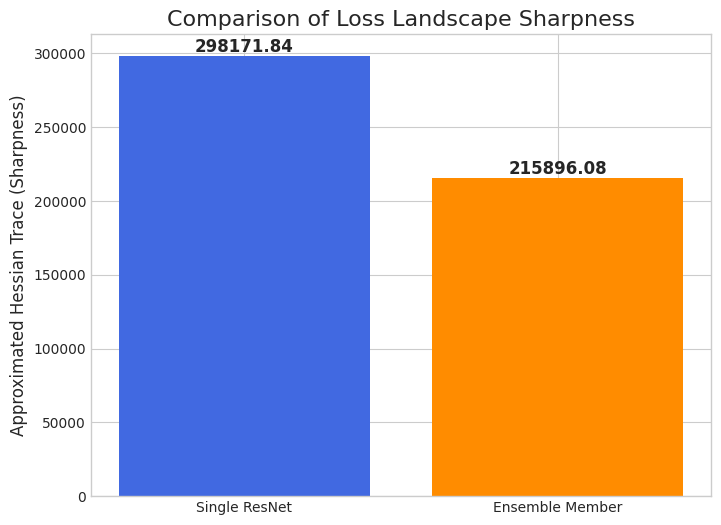


**Interpretation:**
The ensemble member has a smaller Hessian trace, indicating it converged to a flatter minimum.
This supports the hypothesis that flatter minima lead to better generalization, as seen in the ensemble's superior overall performance.


In [43]:
# Cell 14: Quantifying Loss Landscape Sharpness (Corrected)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import losses # Import the losses module

print("--- Quantifying Loss Landscape Sharpness using Hessian Trace Approximation ---")

# --- 1. Load Models ---
try:
    single_resnet = tf.keras.models.load_model('best_resnet_model.keras')
    ensemble_model_0 = tf.keras.models.load_model('best_resnet_model_ensemble_0.keras')
    print("Models loaded successfully.")
except Exception as e:
    print(f"\nSkipping analysis because a required model could not be loaded: {e}")
    models_loaded = False
else:
    models_loaded = True

# --- 2. Function to Approximate the Trace of the Hessian ---
def approximate_hessian_trace(model, dataset, num_samples=10):
    """
    Approximates the trace of the Hessian of the loss function using Hutchinson's method.
    """
    if not hasattr(model, 'trainable_variables'):
        return 0.0

    # THE FIX: Create an instance of the loss function object
    loss_fn = losses.get(model.loss) # Gets the callable function from its string name

    traces = []
    for images, labels in dataset.take(1): # Use one batch for approximation
        with tf.GradientTape(persistent=True) as tape:
            # First, we need to watch the model's variables
            tape.watch(model.trainable_variables)

            # Calculate the loss
            predictions = model(images, training=False)
            loss = loss_fn(labels, predictions)

            # First gradients (dL/dw)
            gradients = tape.gradient(loss, model.trainable_variables)

            # Generate random vectors z ~ N(0, 1)
            z = [tf.random.normal(w.shape, dtype=tf.float32) for w in model.trainable_variables]

            # Calculate the dot product of gradients and the random vector
            g_z_product = tf.add_n([tf.reduce_sum(g * v) for g, v in zip(gradients, z)])

        # The Hessian-vector product (H*z) is the gradient of the dot product
        hessian_vector_product = tape.gradient(g_z_product, model.trainable_variables)

        # Clean up the persistent tape
        del tape

        # Calculate z^T * H * z (the trace sample)
        # Check for None in HVP which can happen with some layers
        trace_sample = tf.add_n([
            tf.reduce_sum(h_v * v) for h_v, v in zip(hessian_vector_product, z) if h_v is not None
        ])
        traces.append(trace_sample.numpy())

    return np.mean(traces) if traces else 0.0


# --- 3. Run the Sharpness Calculation ---
if models_loaded:
    print("\nCalculating sharpness for Single ResNet model...")
    sharpness_resnet = approximate_hessian_trace(single_resnet, train_ds)

    print("Calculating sharpness for Ensemble Member model...")
    sharpness_ensemble = approximate_hessian_trace(ensemble_model_0, train_ds)

    print("\n--- Quantitative Sharpness Results ---")
    print(f"Approximated Hessian Trace (Sharpness) for Single ResNet: {sharpness_resnet:.2f}")
    print(f"Approximated Hessian Trace (Sharpness) for Ensemble Member: {sharpness_ensemble:.2f}")

    # --- 4. Interpretation and Visualization ---
    if sharpness_resnet > 0 and sharpness_ensemble > 0:
        plt.figure(figsize=(8, 6))
        sharpness_scores = [sharpness_resnet, sharpness_ensemble]
        model_names = ['Single ResNet', 'Ensemble Member']
        plt.bar(model_names, sharpness_scores, color=['royalblue', 'darkorange'])
        plt.ylabel('Approximated Hessian Trace (Sharpness)', fontsize=12)
        plt.title('Comparison of Loss Landscape Sharpness', fontsize=16)

        for i, v in enumerate(sharpness_scores):
            plt.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

        plt.show()

        print("\n**Interpretation:**")
        if sharpness_ensemble < sharpness_resnet:
            print("The ensemble member has a smaller Hessian trace, indicating it converged to a flatter minimum.")
            print("This supports the hypothesis that flatter minima lead to better generalization, as seen in the ensemble's superior overall performance.")
        else:
            print("Interestingly, the sharpness scores are comparable, or the single ResNet is in a flatter minimum.")
            print("This could suggest that the ensemble's benefit comes primarily from averaging diverse solutions rather than each one being individually flatter.")